In [14]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [15]:
now = datetime.now()
print("Last ran on: ")
print(str(now))

Last ran on: 
2021-08-11 08:41:26.830261


In [16]:
## Read data

In [17]:
df_hungary = pd.read_excel('Hungary Swaps Python Data vF.xlsx')
df_poland = pd.read_excel('Poland Swaps Python Data vF.xlsx')
df_czech = pd.read_excel('Czech Swaps Python Data vF.xlsx')
df_israel = pd.read_excel('Israel Swaps Python Data vF.xlsx')
df_southafrica = pd.read_excel('South Africa Swaps Python Data vF.xlsx')
df_russia = pd.read_excel('Russia Swaps Python Data vF.xlsx')
df_turkey = pd.read_excel('Turkey Swaps Python Data vF.xlsx')
df_indonesia = pd.read_excel('Indonesia Swaps Python Data vF.xlsx')
df_thailand = pd.read_excel('Thailand Swaps Python Data vF.xlsx')
# df_philippines = pd.read_excel('Philippines Swaps Python Data vF.xlsx')
df_india = pd.read_excel('India Swaps Python Data vF.xlsx')
df_korea = pd.read_excel('Korea Swaps Python Data vF.xlsx')
df_china = pd.read_excel('China Swaps Python Data vF.xlsx')
df_mexico = pd.read_excel('Mexico Swaps Python Data vF.xlsx')
df_brazil = pd.read_excel('Brazil Swaps Python Data vF.xlsx')
df_chile = pd.read_excel('Chile Swaps Python Data vF.xlsx')
# df_colombia = pd.read_excel('Colombia Swaps Python Data vF.xlsx')
# df_peru = pd.read_excel('Peru Swaps Python Data vF.xlsx')

In [18]:
## Define functions

In [19]:
#defining plot series function
def plot_series(series):
    plt.figure(figsize=(6,3))
    plt.plot(series, color = 'red')
    
    plt.title(series.name, fontsize = 16)
    
    for year in range(2014, df_hungary.index[-1].year+1):
        plt.axvline(datetime(year,1,1), linestyle = '--', color = 'k', alpha = 0.5)
    plt.show()

In [20]:
#defining z-score function
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [21]:
#defining Agumented Dickey-Fuller test
def perform_adf_test(series):
    result = adfuller(series.dropna())
    print(series.name)
    print('ADF Statistic %f' % result[0])
    print('p-value: %f' % result[1])

In [22]:
def transform_data(df):
    #convert date column to datetime type
    df['Dates'] = pd.to_datetime(df.Dates)
    
    #set date as index
    df.set_index('Dates', inplace=True)
    
    #setting start and end dates
    start_date = datetime(2014, 1, 31)
    end_date = df.index[-1]
    lim_df = df[start_date:end_date]
    
    #create dataframe for moving averages (3 month and 6 month)
    ma2 = pd.DataFrame()
    ma3 = pd.DataFrame()
    ma6 = pd.DataFrame()
    ma12 = pd.DataFrame()

    for x in lim_df.columns:
        ma2[lim_df[x].name + ' ma2'] = lim_df[x].rolling(window=2).mean()
        ma3[lim_df[x].name + ' ma3'] = lim_df[x].rolling(window=3).mean()
        ma6[lim_df[x].name + ' ma6'] = lim_df[x].rolling(window=6).mean()
        ma12[lim_df[x].name + ' ma12'] = lim_df[x].rolling(window=12).mean()
        
    #create dataframe for z-scores
    zscores = pd.DataFrame()
    for x in lim_df.columns:
        zscores[lim_df[x].name + ' z'] = zscore(lim_df[x], 24)
        
    #combine dataframes with moving averages and z-scores
    lim_dfz = pd.concat([lim_df, zscores], axis=1).reindex(lim_df.index)
    
    #drop infinity values for each series
    for x in lim_dfz.columns:
        filterx = lim_dfz[x].isin([np.nan, np.inf, -np.inf])
        lim_dfz[x] = lim_dfz[x][~filterx]
        
    #create dataframe for nonstationary and stationary variables
    nonstationary = pd.DataFrame()
    stationary = pd.DataFrame()
    for x in lim_dfz.columns:
        result = adfuller(lim_dfz[x].dropna())
        if result[1] > 0.05:
            nonstationary[lim_dfz[x].name] = lim_dfz[x]
        else:
            stationary[lim_dfz[x].name] = lim_dfz[x]
            
    #take YoY % change for each nonstationary series
    yoy = pd.DataFrame()
    for x in nonstationary.columns:
        yoy[nonstationary[x].name + ' y1'] = (nonstationary[x] / nonstationary[x].shift(12) - 1)*100
        
    #also take first difference of dependent variable
    yoy['10Y y1'] = (lim_df['10Y'] / lim_df['10Y'].shift(12) - 1) * 100
    yoy['2Y Swap y1'] = (lim_df['2Y Swap'] / lim_df['2Y Swap'].shift(12) - 1) * 100
    yoy['5Y Swap y1'] = (lim_df['5Y Swap'] / lim_df['5Y Swap'].shift(12) - 1) * 100
#     yoy['10Y Swap y1'] = (lim_df['10Y Swap'] / lim_df['10Y Swap'].shift(12) - 1) * 100
    
    #add extra variables as exception
    exc = pd.DataFrame()
    exc['Policy Rate'] = lim_df['Policy Rate']
    
    #merge stationary variables and MAs into one data frame
    lim_df_sta = pd.DataFrame()
    lim_df_sta = pd.concat([stationary,yoy,ma2, ma3, ma6, ma12, exc], axis=1).reindex(yoy.index)
    
    #create dataframe for lagged variables
    lag_1 = pd.DataFrame()
    for x in lim_df_sta.columns:
        lag_1[lim_df_sta[x].name + ' p1'] = lim_df_sta[x].shift(1).dropna()
    
    #merge all (stationary) variables into one data frame
    lim_df_sta = pd.concat([lim_df_sta, lag_1], axis=1).reindex(lag_1.index)
    
    #add undifferenced dependent variable
    lim_df_sta['10Y'] = lim_df['10Y']
    lim_df_sta['2Y Swap'] = lim_df['2Y Swap']
    lim_df_sta['5Y Swap'] = lim_df['5Y Swap']
#     lim_df_sta['10Y Swap'] = lim_df['10Y Swap']
    
    #(exp) drop infinity values for each series
    for x in lim_df_sta.columns:
        filterx = lim_df_sta[x].isin([np.nan, np.inf, -np.inf])
        lim_df_sta[x] = lim_df_sta[x][~filterx]
    
    #dump data in excel
    lim_df_sta.to_excel('data transformation dump.xlsx')
    
    #read data
    lim_df_sta2 = pd.read_excel('data transformation dump.xlsx')

In [23]:
#regression and results for 5Y Swap as dependent variable
def regress(Y, X):

    #clean the data
    Y = Y.dropna()
    X = X.dropna()
    
    #make Y matrix the same shape as X
    YX = pd.concat([Y, X], axis=1).reindex(X.index).dropna()
    Y = YX['5Y Swap']
    X = YX.drop(['5Y Swap'], axis = 1)
    
#     print(YX.corr())
    
    #fit the model with a constant
    X1 = sm.add_constant(X)
    reg = sm.OLS(Y, X1).fit()
#     print(reg.summary())

    #create dataframe for coefficients
    p = reg.params
    p = pd.Series(p, name = 'Coefficients')
    p = pd.DataFrame(p)
    
    print('R-Squared = ' + str(reg.rsquared))
    print(p)

    #calculate and plot residuals
    predictions = reg.predict()
    residuals = predictions - Y
   
    plt.figure(figsize=(4,1.5))
    plt.plot(residuals, color = 'blue')
    
    plt.title('Residuals', fontsize = 11)
    
    for year in range(2014, Y.index[-1].year+1):
        plt.axvline(datetime(year,1,1), linestyle = '--', color = 'k', alpha = 0.5)
    plt.show()
    
    #create exportable dataframe for actual data, predictions and residuals
    predictions = pd.Series(predictions, name = 'Predictions', index = Y.index)
    results = pd.DataFrame(predictions, index = Y.index)
    results['Actual 5Y Swap'] = Y
    results['Residuals'] = results['Predictions'] - results['Actual 5Y Swap']

    #dump data in excel
    results.to_excel('reg data dump.xlsx')
    
#     #plot actual data vs. predictions
#     predictions = pd.Series(predictions, index = Y.index)
#     plt.figure(figsize=(20,7))
#     plt.plot(Y)
#     plt.plot(predictions)
#     plt.legend(('Actual', 'Model Fit'), fontsize = 20)
#     plt.title('Full Year Model Fit for 5Y Swap (%)', fontsize = 20)
#     plt.show()

#     #divide training and test data
#     train_end = datetime(2020,6,30)
#     test_start = datetime(2020,7,31)
#     train_Y = Y[:train_end]
#     train_X1 = X1[:train_end]
#     test_Y = Y[test_start:]
#     test_X1 = X1[test_start:]

#     #fit training model
#     training_model = sm.OLS(train_Y, train_X1).fit()

#     #predict test data
#     test_predictions = training_model.predict(test_X1)
#     test_predictions = pd.Series(test_predictions, index = test_X1.index)

#     #plot test data predictions vs. actual data
#     plt.figure(figsize=(20,7))
#     plt.plot(test_Y)
#     plt.plot(test_predictions)
#     plt.legend(('Actual', 'Model Fit'), fontsize = 20)
#     plt.title('Out of Sample Test for 5Y Swap Yield (%)', fontsize = 20)
#     plt.show()

#     #print actual test data in a table
#     summary = pd.DataFrame(test_Y)
#     summary['Predictions'] = test_predictions
#     summary['Difference'] = summary['Predictions'] - summary['5Y Swap']
#     print(summary)

In [24]:
#regression and results for 5Y Swap y1 as dependent variable
def regress_y(lim_df, Y, X):

    #clean the data
    Y = Y.dropna()
    X = X.dropna()
    
    #make Y matrix the same shape as X
    YX = pd.concat([Y, X], axis=1).reindex(Y.index).dropna()
    Y = YX['5Y Swap y1']
    X = YX.drop(['5Y Swap y1'], axis = 1)
    
#     print(YX.corr())
    
    #fit the model with a constant
    X1 = sm.add_constant(X)
    reg = sm.OLS(Y, X1).fit()
#     print(reg.summary())

    #create dataframe for coefficients
    p = reg.params
    p = pd.Series(p, name = 'Coefficients')
    p = pd.DataFrame(p)

    print('R-Squared = ' + str(reg.rsquared))
    print(p)

    #calculate and plot residuals
    predictions = reg.predict()
    residuals = predictions - Y
    
    plt.figure(figsize=(4,1.5))
    plt.plot(residuals, color = 'blue')
    
    plt.title('Residuals', fontsize = 11)
    
    for year in range(2014, Y.index[-1].year+1):
        plt.axvline(datetime(year,1,1), linestyle = '--', color = 'k', alpha = 0.5)
    plt.show()
    
    #plot actual data vs. predictions
    predictions = pd.Series(predictions, name = 'predicted_yoys', index=Y.index)
    predictions_untrans = pd.DataFrame(predictions, index = lim_df.index)
    predictions_untrans['predicted_yoys'] = predictions_untrans['predicted_yoys'].fillna(0)
    predictions_untrans['Actual 5Y Swap'] = lim_df['5Y Swap']
    predictions_untrans['Predictions'] = np.zeros_like(lim_df['5Y Swap'])
    predictions_untrans['Predictions'][0] = predictions_untrans['Actual 5Y Swap'][0]

    for t in range(1, 12):
        predictions_untrans['Predictions'][t] = predictions_untrans['Actual 5Y Swap'][t]

    for t in range(12, len(predictions_untrans['Actual 5Y Swap'])):
        if predictions_untrans['predicted_yoys'][t] == 0:
            predictions_untrans['Predictions'][t] = predictions_untrans['Actual 5Y Swap'][t]
        else:
            predictions_untrans['Predictions'][t] = predictions_untrans['Predictions'][t-12] * (1 + predictions_untrans['predicted_yoys'][t]/100)

    predictions_untrans['Residuals'] = predictions_untrans['Predictions'] - predictions_untrans['Actual 5Y Swap']
    
    #dump data in excel
    predictions_untrans.to_excel('reg data dump.xlsx')
        
#     plt.figure(figsize=(20,7))
#     plt.plot(predictions_untrans['Actual 5Y Swap'])
#     plt.plot(predictions_untrans['Predictions'])
#     plt.legend(('Actual', 'Predicted'), fontsize = 20)
#     plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
#     plt.show()

#     #divide training and test data
#     train_end = datetime(2020,6,30)
#     test_start = datetime(2020,7,31)
#     train_Y = Y[:train_end]
#     train_X1 = X1[:train_end]
#     test_Y = Y[test_start:]
#     test_X1 = X1[test_start:]

#     #fit training model
#     training_model = sm.OLS(train_Y, train_X1).fit()

#     #predict test data
#     test_predictions = training_model.predict(test_X1)
#     test_predictions = pd.Series(test_predictions, index = test_X1.index)

#     #plot test data predictions vs. actual data
#     plt.figure(figsize=(20,7))
#     plt.plot(test_Y)
#     plt.plot(test_predictions)
#     plt.legend(('Actual', 'Model Fit'), fontsize = 20)
#     plt.title('Out of Sample Test for 5Y Swap Yield (%)', fontsize = 20)
#     plt.show()

#     #print actual test data in a table
#     summary = pd.DataFrame(test_Y)
#     summary['Predictions'] = test_predictions
#     summary['Difference'] = summary['Predictions'] - summary['5Y Swap y1']
#     print(summary)

In [25]:
## Analyze data

In [26]:
#transform data for all countries
transform_data(df_hungary)
df_hungary_sta = pd.read_excel('data transformation dump.xlsx')
df_hungary_sta['Dates'] = pd.to_datetime(df_hungary_sta.Dates)
df_hungary_sta.set_index('Dates', inplace=True)

transform_data(df_poland)
df_poland_sta = pd.read_excel('data transformation dump.xlsx')
df_poland_sta['Dates'] = pd.to_datetime(df_poland_sta.Dates)
df_poland_sta.set_index('Dates', inplace=True)

transform_data(df_czech)
df_czech_sta = pd.read_excel('data transformation dump.xlsx')
df_czech_sta['Dates'] = pd.to_datetime(df_czech_sta.Dates)
df_czech_sta.set_index('Dates', inplace=True)

transform_data(df_israel)
df_israel_sta = pd.read_excel('data transformation dump.xlsx')
df_israel_sta['Dates'] = pd.to_datetime(df_israel_sta.Dates)
df_israel_sta.set_index('Dates', inplace=True)

transform_data(df_southafrica)
df_southafrica_sta = pd.read_excel('data transformation dump.xlsx')
df_southafrica_sta['Dates'] = pd.to_datetime(df_southafrica_sta.Dates)
df_southafrica_sta.set_index('Dates', inplace=True)

transform_data(df_russia)
df_russia_sta = pd.read_excel('data transformation dump.xlsx')
df_russia_sta['Dates'] = pd.to_datetime(df_russia_sta.Dates)
df_russia_sta.set_index('Dates', inplace=True)

transform_data(df_turkey)
df_turkey_sta = pd.read_excel('data transformation dump.xlsx')
df_turkey_sta['Dates'] = pd.to_datetime(df_turkey_sta.Dates)
df_turkey_sta.set_index('Dates', inplace=True)

transform_data(df_indonesia)
df_indonesia_sta = pd.read_excel('data transformation dump.xlsx')
df_indonesia_sta['Dates'] = pd.to_datetime(df_indonesia_sta.Dates)
df_indonesia_sta.set_index('Dates', inplace=True)

transform_data(df_thailand)
df_thailand_sta = pd.read_excel('data transformation dump.xlsx')
df_thailand_sta['Dates'] = pd.to_datetime(df_thailand_sta.Dates)
df_thailand_sta.set_index('Dates', inplace=True)

# transform_data(df_philippines)
# df_philippines_sta = pd.read_excel('data transformation dump.xlsx')
# df_philippines_sta['Dates'] = pd.to_datetime(df_philippines_sta.Dates)
# df_philippines_sta.set_index('Dates', inplace=True)

transform_data(df_india)
df_india_sta = pd.read_excel('data transformation dump.xlsx')
df_india_sta['Dates'] = pd.to_datetime(df_india_sta.Dates)
df_india_sta.set_index('Dates', inplace=True)

transform_data(df_korea)
df_korea_sta = pd.read_excel('data transformation dump.xlsx')
df_korea_sta['Dates'] = pd.to_datetime(df_korea_sta.Dates)
df_korea_sta.set_index('Dates', inplace=True)

transform_data(df_china)
df_china_sta = pd.read_excel('data transformation dump.xlsx')
df_china_sta['Dates'] = pd.to_datetime(df_china_sta.Dates)
df_china_sta.set_index('Dates', inplace=True)

transform_data(df_mexico)
df_mexico_sta = pd.read_excel('data transformation dump.xlsx')
df_mexico_sta['Dates'] = pd.to_datetime(df_mexico_sta.Dates)
df_mexico_sta.set_index('Dates', inplace=True)

transform_data(df_brazil)
df_brazil_sta = pd.read_excel('data transformation dump.xlsx')
df_brazil_sta['Dates'] = pd.to_datetime(df_brazil_sta.Dates)
df_brazil_sta.set_index('Dates', inplace=True)

transform_data(df_chile)
df_chile_sta = pd.read_excel('data transformation dump.xlsx')
df_chile_sta['Dates'] = pd.to_datetime(df_chile_sta.Dates)
df_chile_sta.set_index('Dates', inplace=True)

# transform_data(df_colombia)
# df_colombia_sta = pd.read_excel('data transformation dump.xlsx')
# df_colombia_sta['Dates'] = pd.to_datetime(df_colombia_sta.Dates)
# df_colombia_sta.set_index('Dates', inplace=True)

# transform_data(df_peru)
# df_peru_sta = pd.read_excel('data transformation dump.xlsx')
# df_peru_sta['Dates'] = pd.to_datetime(df_peru_sta.Dates)
# df_peru_sta.set_index('Dates', inplace=True)

In [27]:
# #export correlation matrices
# df_hungary_sta.corr().to_excel('Correlation_Matrix_Hungary.xlsx')
# df_poland_sta.corr().to_excel('Correlation_Matrix_Poland.xlsx')
# df_czech_sta.corr().to_excel('Correlation_Matrix_Czech.xlsx')
# df_israel_sta.corr().to_excel('Correlation_Matrix_Israel.xlsx')
# df_southafrica_sta.corr().to_excel('Correlation_Matrix_SouthAfrica.xlsx')
# df_russia_sta.corr().to_excel('Correlation_Matrix_Russia.xlsx')
# df_turkey_sta.corr().to_excel('Correlation_Matrix_Turkey.xlsx')
# df_indonesia_sta.corr().to_excel('Correlation_Matrix_Indonesia.xlsx')
# df_thailand_sta.corr().to_excel('Correlation_Matrix_Thailand.xlsx')
# df_philippines_sta.corr().to_excel('Correlation_Matrix_Philippines.xlsx')
# df_india_sta.corr().to_excel('Correlation_Matrix_India.xlsx')
# df_korea_sta.corr().to_excel('Correlation_Matrix_Korea.xlsx')
# df_china_sta.corr().to_excel('Correlation_Matrix_China.xlsx')
# df_mexico_sta.corr().to_excel('Correlation_Matrix_Mexico.xlsx')
# df_brazil_sta.corr().to_excel('Correlation_Matrix_Brazil.xlsx')
# df_chile_sta.corr().to_excel('Correlation_Matrix_Chile.xlsx')
# df_colombia_sta.corr().to_excel('Correlation_Matrix_Colombia.xlsx')
# df_peru_sta.corr().to_excel('Correlation_Matrix_Peru.xlsx')

In [28]:
## Regressions

*****

## Hungary

In [29]:
#set dependent variables
Y = df_hungary_sta['5Y Swap']
Y_y = df_hungary_sta['5Y Swap y1']

Model 1
R-Squared = 0.483187051126
                               Coefficients
const                              0.089807
EUR Swap 10Y ma2                   0.503316
Gov Budget Forecast 1Y ma6 p1     -0.539256


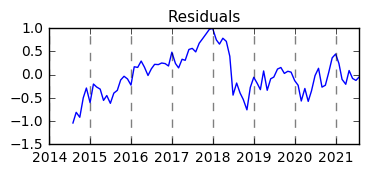

In [32]:
#model 1
X1 = df_hungary_sta[['EUR Swap 10Y ma2',
                     'Gov Budget Forecast 1Y ma6 p1'
               ]]
print('Model 1')
regress(Y,X1)

#read the data
results_hungary_1 = pd.read_excel('reg data dump.xlsx')
results_hungary_1['Dates'] = pd.to_datetime(results_hungary_1.Dates)
results_hungary_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.512434167648
                               Coefficients
const                              1.852027
CT10 ma2                           0.224371
Industrial Production ma6         -0.020421
Gov Budget Forecast 1Y ma6 p1     -0.592983


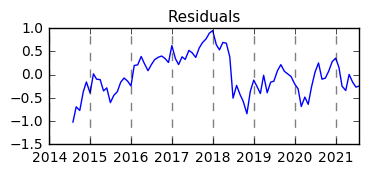

In [33]:
#model 2
X2 = df_hungary_sta[['CT10 ma2',
                     'Industrial Production ma6',
                     'Gov Budget Forecast 1Y ma6 p1'
               ]]
print('Model 2')
regress(Y, X2)

#read the data
results_hungary_2 = pd.read_excel('reg data dump.xlsx')
results_hungary_2['Dates'] = pd.to_datetime(results_hungary_2.Dates)
results_hungary_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.637573023118
                       Coefficients
const                     -0.813766
Unemployment Rate ma2      0.369278
CT10 ma2                   0.330153


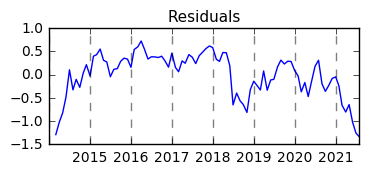

In [34]:
#model 3
X3 = df_hungary_sta[['Unemployment Rate ma2',
                     'CT10 ma2'
               ]]
print('Model 3')
regress(Y, X3)

#read the data
results_hungary_3 = pd.read_excel('reg data dump.xlsx')
results_hungary_3['Dates'] = pd.to_datetime(results_hungary_3.Dates)
results_hungary_3.set_index('Dates', inplace=True)

Model 4
R-Squared = 0.654320912488
                               Coefficients
const                              1.742555
GDP Forecast 2Y ma2               -0.686340
Gov Budget Forecast 1Y ma6 p1     -0.716272


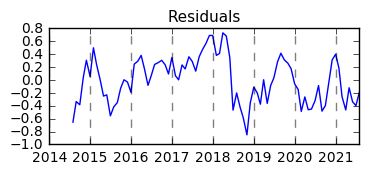

In [35]:
#model 4
X4 = df_hungary_sta[['GDP Forecast 2Y ma2',
                     'Gov Budget Forecast 1Y ma6 p1'
               ]]
print('Model 4')
regress(Y, X4)

#read the data
results_hungary_4 = pd.read_excel('reg data dump.xlsx')
results_hungary_4['Dates'] = pd.to_datetime(results_hungary_4.Dates)
results_hungary_4.set_index('Dates', inplace=True)

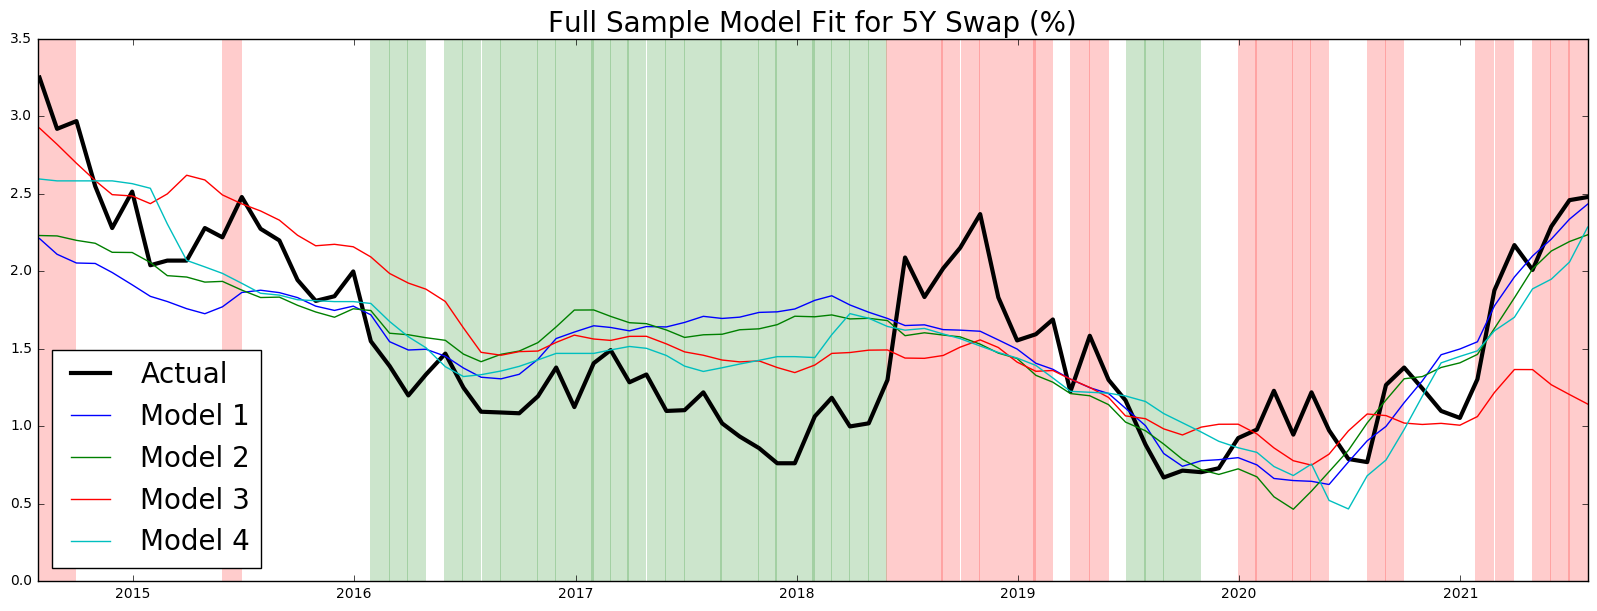

In [36]:
#collect model fits
results_hungary = pd.DataFrame(results_hungary_1['Actual 5Y Swap'])
results_hungary['Actual 5Y Swap'] = results_hungary_1['Actual 5Y Swap']
results_hungary['Model 1'] = results_hungary_1['Predictions']
results_hungary['Model 2'] = results_hungary_2['Predictions']
results_hungary['Model 3'] = results_hungary_3['Predictions']
results_hungary['Model 4'] = results_hungary_4['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_hungary['Regime'] = np.zeros_like(results_hungary['Actual 5Y Swap'])
for t in range(len(results_hungary)):
    if results_hungary['Model 1'][t] < results_hungary['Actual 5Y Swap'][t]\
    and results_hungary['Model 2'][t] < results_hungary['Actual 5Y Swap'][t]\
    and results_hungary['Model 3'][t] < results_hungary['Actual 5Y Swap'][t]\
    and results_hungary['Model 4'][t] < results_hungary['Actual 5Y Swap'][t]:
        results_hungary['Regime'][t] = -1
    
for t in range(len(results_hungary)):
    if results_hungary['Model 1'][t] > results_hungary['Actual 5Y Swap'][t]\
    and results_hungary['Model 2'][t] > results_hungary['Actual 5Y Swap'][t]\
    and results_hungary['Model 3'][t] > results_hungary['Actual 5Y Swap'][t]\
    and results_hungary['Model 4'][t] > results_hungary['Actual 5Y Swap'][t]:
        results_hungary['Regime'][t] = 1

results_hungary['Dates'] = results_hungary.index
results_hungary['Dates'] = results_hungary['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_hungary['Year'] = results_hungary['Dates'].dt.year
results_hungary['Month'] = results_hungary['Dates'].dt.month
results_hungary['Day'] = results_hungary['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_hungary = results_hungary.copy(deep = True)
regime_up_hungary.drop(regime_up_hungary[regime_up_hungary.Regime < 1].index, inplace = True)

regime_down_hungary = results_hungary.copy(deep = True)
regime_down_hungary.drop(regime_down_hungary[regime_down_hungary.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_hungary['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_hungary['Model 1'])
plt.plot(results_hungary['Model 2'])
plt.plot(results_hungary['Model 3'])
plt.plot(results_hungary['Model 4'])

for t in range(1, len(regime_up_hungary)):
    plt.axvspan(datetime(regime_up_hungary['Year'][t], regime_up_hungary['Month'][t], regime_up_hungary['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_hungary['Year'][t], regime_up_hungary['Month'][t], regime_up_hungary['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_hungary)):
    plt.axvspan(datetime(regime_down_hungary['Year'][t], regime_down_hungary['Month'][t], regime_down_hungary['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_hungary['Year'][t], regime_down_hungary['Month'][t], regime_down_hungary['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3', 'Model 4'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

*********

## Poland

In [37]:
#set dependent variables
Y = df_poland_sta['5Y Swap']
Y_y = df_poland_sta['5Y Swap y1']

Model 1
R-Squared = 0.736076302043
                           Coefficients
const                          0.932158
EUR/LC Vol ma12 p1             0.261046
Trade Bal as % GDP SA ma3     -0.085186


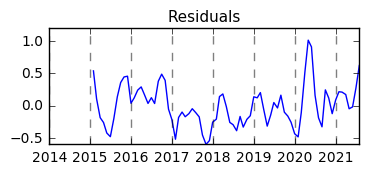

In [38]:
#model 1
X1 = df_poland_sta[['EUR/LC Vol ma12 p1',
                    'Trade Bal as % GDP SA ma3'
               ]]
print('Model 1')
regress(Y, X1)

results_poland_1 = pd.read_excel('reg data dump.xlsx')
results_poland_1['Dates'] = pd.to_datetime(results_poland_1.Dates)
results_poland_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.77814738974
                  Coefficients
const                 8.242299
EUR Swap 10Y ma2      1.335091
REER ma12            -0.074230


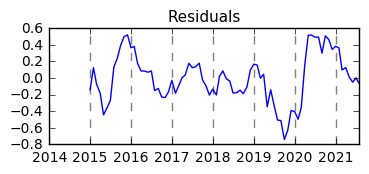

In [41]:
#model 2
X2 = df_poland_sta[['EUR Swap 10Y ma2',
                    'REER ma12'
               ]]
print('Model 2')
regress(Y, X2)

results_poland_2 = pd.read_excel('reg data dump.xlsx')
results_poland_2['Dates'] = pd.to_datetime(results_poland_2.Dates)
results_poland_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.798643151391
                          Coefficients
const                         2.931258
1Y ma2                        0.794959
REER ma12                    -0.021240
Reserves Import Cover y1     -0.016106


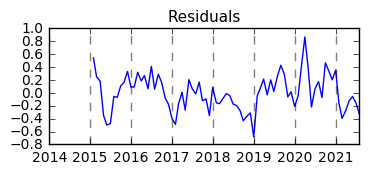

In [42]:
#model 3
X3 = df_poland_sta[['1Y ma2',
                    'REER ma12',
                    'Reserves Import Cover y1'
               ]]
print('Model 3')
regress(Y, X3)

results_poland_3 = pd.read_excel('reg data dump.xlsx')
results_poland_3['Dates'] = pd.to_datetime(results_poland_3.Dates)
results_poland_3.set_index('Dates', inplace=True)

Model 4
R-Squared = 0.773476932448
                           Coefficients
const                          0.501498
USD/LC Vol ma12                0.189689
Trade Bal as % GDP SA ma3     -0.070471
Reserves Import Cover y1      -0.009655


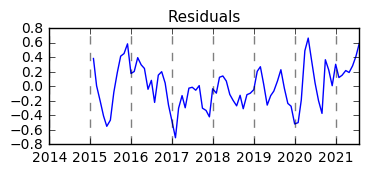

In [43]:
#model 4
X4 = df_poland_sta[['USD/LC Vol ma12',
                    'Trade Bal as % GDP SA ma3',
                    'Reserves Import Cover y1'
               ]]
print('Model 4')
regress(Y, X4)

results_poland_4 = pd.read_excel('reg data dump.xlsx')
results_poland_4['Dates'] = pd.to_datetime(results_poland_4.Dates)
results_poland_4.set_index('Dates', inplace=True)

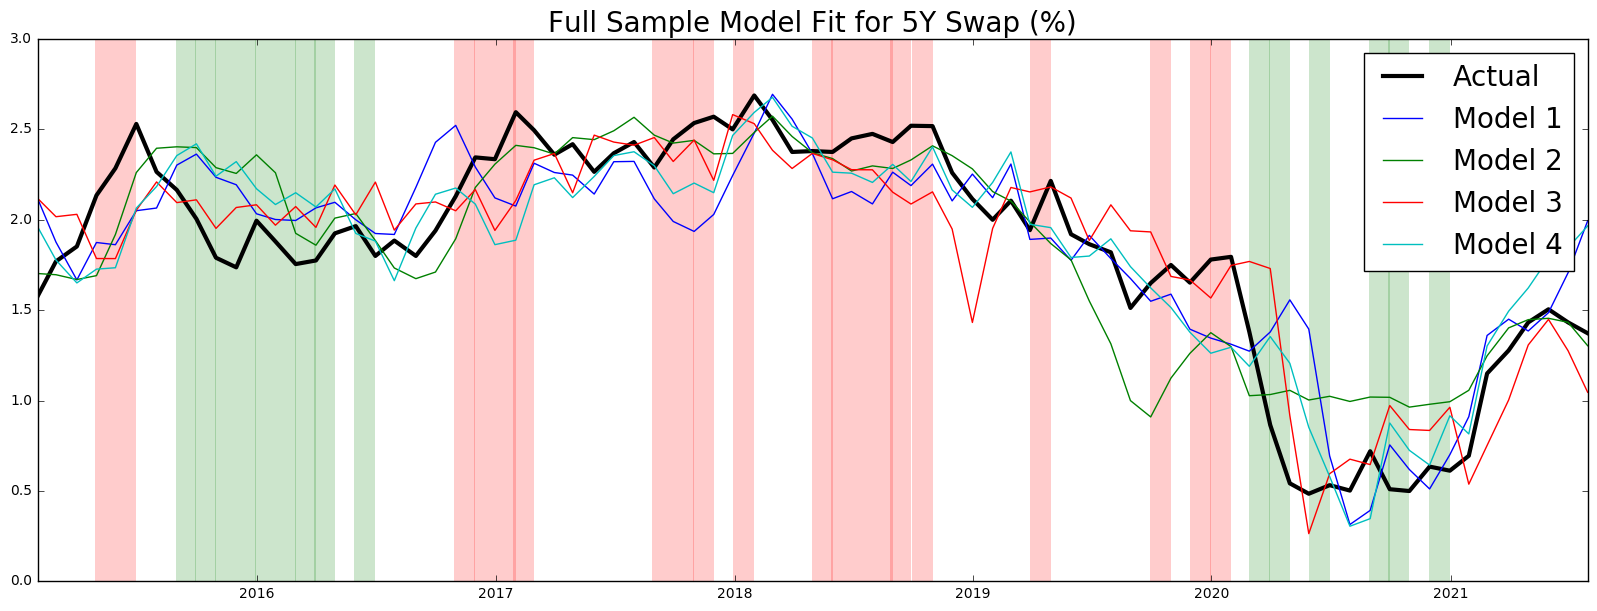

In [44]:
#collect model fits
results_poland = pd.DataFrame(results_poland_1['Actual 5Y Swap'])
results_poland['Actual 5Y Swap'] = results_poland_1['Actual 5Y Swap']
results_poland['Model 1'] = results_poland_1['Predictions']
results_poland['Model 2'] = results_poland_2['Predictions']
results_poland['Model 3'] = results_poland_3['Predictions']
results_poland['Model 4'] = results_poland_4['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_poland['Regime'] = np.zeros_like(results_poland['Actual 5Y Swap'])
for t in range(len(results_poland)):
    if results_poland['Model 1'][t] < results_poland['Actual 5Y Swap'][t]\
    and results_poland['Model 2'][t] < results_poland['Actual 5Y Swap'][t]\
    and results_poland['Model 3'][t] < results_poland['Actual 5Y Swap'][t]\
    and results_poland['Model 4'][t] < results_poland['Actual 5Y Swap'][t]:
        results_poland['Regime'][t] = -1
    
for t in range(len(results_poland)):
    if results_poland['Model 1'][t] > results_poland['Actual 5Y Swap'][t]\
    and results_poland['Model 2'][t] > results_poland['Actual 5Y Swap'][t]\
    and results_poland['Model 3'][t] > results_poland['Actual 5Y Swap'][t]\
    and results_poland['Model 4'][t] > results_poland['Actual 5Y Swap'][t]:
        results_poland['Regime'][t] = 1

results_poland['Dates'] = results_poland.index
results_poland['Dates'] = results_poland['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_poland['Year'] = results_poland['Dates'].dt.year
results_poland['Month'] = results_poland['Dates'].dt.month
results_poland['Day'] = results_poland['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_poland = results_poland.copy(deep = True)
regime_up_poland.drop(regime_up_poland[regime_up_poland.Regime < 1].index, inplace = True)

regime_down_poland = results_poland.copy(deep = True)
regime_down_poland.drop(regime_down_poland[regime_down_poland.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_poland['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_poland['Model 1'])
plt.plot(results_poland['Model 2'])
plt.plot(results_poland['Model 3'])
plt.plot(results_poland['Model 4'])

for t in range(1, len(regime_up_poland)):
    plt.axvspan(datetime(regime_up_poland['Year'][t], regime_up_poland['Month'][t], regime_up_poland['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_poland['Year'][t], regime_up_poland['Month'][t], regime_up_poland['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_poland)):
    plt.axvspan(datetime(regime_down_poland['Year'][t], regime_down_poland['Month'][t], regime_down_poland['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_poland['Year'][t], regime_down_poland['Month'][t], regime_down_poland['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3', 'Model 4'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Czech

In [45]:
#set dependent variables
Y = df_czech_sta['5Y Swap']
Y_y = df_czech_sta['5Y Swap y1']

Model 1
R-Squared = 0.817930237682
                      Coefficients
const                    -9.051258
CPI Forecast 1Y ma12      4.743769
Policy Rate               0.507244
CT10 ma3                  0.209766


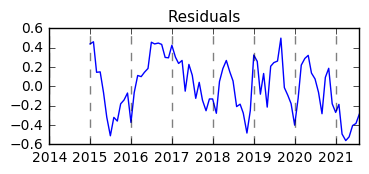

In [46]:
#model 1
X1 = df_czech_sta[['CPI Forecast 1Y ma12',
                   'Policy Rate',
                   'CT10 ma3'
                   ]]
print('Model 1')
regress(Y, X1)

results_czech_1 = pd.read_excel('reg data dump.xlsx')
results_czech_1['Dates'] = pd.to_datetime(results_czech_1.Dates)
results_czech_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.548935390989
                                Coefficients
const                             -11.677529
Trade Bal as % GDP SA ma12         -0.317113
CPI Forecast 1Y ma12                6.536038
Gov Budget as % GDP SA ma12 p1     -0.019333


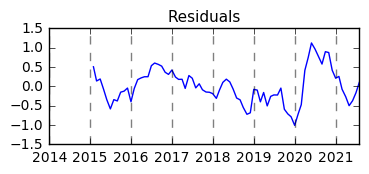

In [47]:
#model 2
X2 = df_czech_sta[['Trade Bal as % GDP SA ma12',
                   'CPI Forecast 1Y ma12',
                   'Gov Budget as % GDP SA ma12 p1'
                   ]]
print('Model 2')
regress(Y, X2)

results_czech_2 = pd.read_excel('reg data dump.xlsx')
results_czech_2['Dates'] = pd.to_datetime(results_czech_2.Dates)
results_czech_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.598238768565
                                Coefficients
const                               3.962845
USD/LC Vol ma2                     -0.294180
Trade Bal as % GDP SA ma12         -0.134069
Gov Budget as % GDP SA ma12 p1     -0.011682


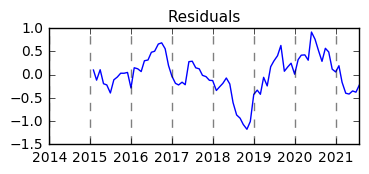

In [48]:
#model 3
X3 = df_czech_sta[['USD/LC Vol ma2',
                   'Trade Bal as % GDP SA ma12',
                   'Gov Budget as % GDP SA ma12 p1'
                   ]]
print('Model 3')
regress(Y, X3)

results_czech_3 = pd.read_excel('reg data dump.xlsx')
results_czech_3['Dates'] = pd.to_datetime(results_czech_3.Dates)
results_czech_3.set_index('Dates', inplace=True)

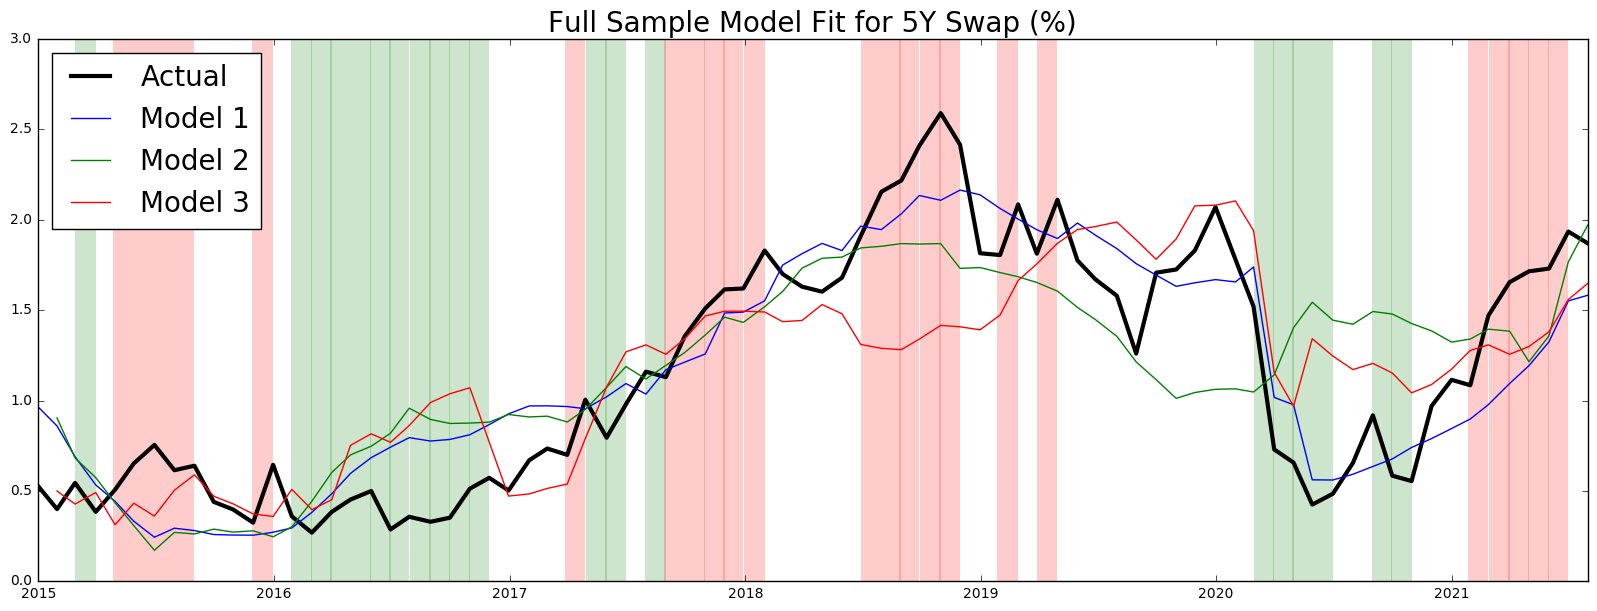

In [49]:
#collect model fits
results_czech = pd.DataFrame(results_czech_1['Actual 5Y Swap'])
results_czech['Actual 5Y Swap'] = results_czech_1['Actual 5Y Swap']
results_czech['Model 1'] = results_czech_1['Predictions']
results_czech['Model 2'] = results_czech_2['Predictions']
results_czech['Model 3'] = results_czech_3['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_czech['Regime'] = np.zeros_like(results_czech['Actual 5Y Swap'])
for t in range(len(results_czech)):
    if results_czech['Model 1'][t] < results_czech['Actual 5Y Swap'][t]\
    and results_czech['Model 2'][t] < results_czech['Actual 5Y Swap'][t]\
    and results_czech['Model 3'][t] < results_czech['Actual 5Y Swap'][t]:
        results_czech['Regime'][t] = -1
    
for t in range(len(results_czech)):
    if results_czech['Model 1'][t] > results_czech['Actual 5Y Swap'][t]\
    and results_czech['Model 2'][t] > results_czech['Actual 5Y Swap'][t]\
    and results_czech['Model 3'][t] > results_czech['Actual 5Y Swap'][t]:
        results_czech['Regime'][t] = 1

results_czech['Dates'] = results_czech.index
results_czech['Dates'] = results_czech['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_czech['Year'] = results_czech['Dates'].dt.year
results_czech['Month'] = results_czech['Dates'].dt.month
results_czech['Day'] = results_czech['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_czech = results_czech.copy(deep = True)
regime_up_czech.drop(regime_up_czech[regime_up_czech.Regime < 1].index, inplace = True)

regime_down_czech = results_czech.copy(deep = True)
regime_down_czech.drop(regime_down_czech[regime_down_czech.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_czech['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_czech['Model 1'])
plt.plot(results_czech['Model 2'])
plt.plot(results_czech['Model 3'])

for t in range(1, len(regime_up_czech)):
    plt.axvspan(datetime(regime_up_czech['Year'][t], regime_up_czech['Month'][t], regime_up_czech['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_czech['Year'][t], regime_up_czech['Month'][t], regime_up_czech['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_czech)):
    plt.axvspan(datetime(regime_down_czech['Year'][t], regime_down_czech['Month'][t], regime_down_czech['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_czech['Year'][t], regime_down_czech['Month'][t], regime_down_czech['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Israel

In [50]:
#set dependent variables
Y = df_israel_sta['5Y Swap']
Y_y = df_israel_sta['5Y Swap y1']

Model 1
R-Squared = 0.812030969375
             Coefficients
const            5.473082
CT10 ma3         0.387319
Rating ma2      -0.348160
Policy Rate      0.985737


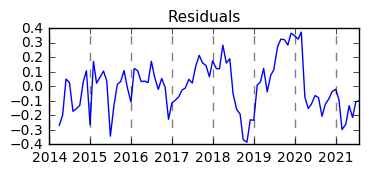

In [51]:
#model 1
X1 = df_israel_sta[['CT10 ma3',
                    'Rating ma2',
                    'Policy Rate'
                   ]]
print('Model 1')
regress(Y, X1)

results_israel_1 = pd.read_excel('reg data dump.xlsx')
results_israel_1['Dates'] = pd.to_datetime(results_israel_1.Dates)
results_israel_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.86109316496
                          Coefficients
const                        -1.052809
CT10 ma3                      0.446373
Policy Rate                   0.739023
Unemployment Rate ma2 p1      0.187946


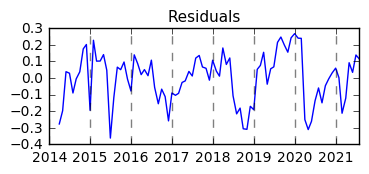

In [52]:
#model 2
X2 = df_israel_sta[['CT10 ma3',
                    'Policy Rate',
                    'Unemployment Rate ma2 p1'
                   ]]
print('Model 2')
regress(Y, X2)

results_israel_2 = pd.read_excel('reg data dump.xlsx')
results_israel_2['Dates'] = pd.to_datetime(results_israel_2.Dates)
results_israel_2.set_index('Dates', inplace=True)

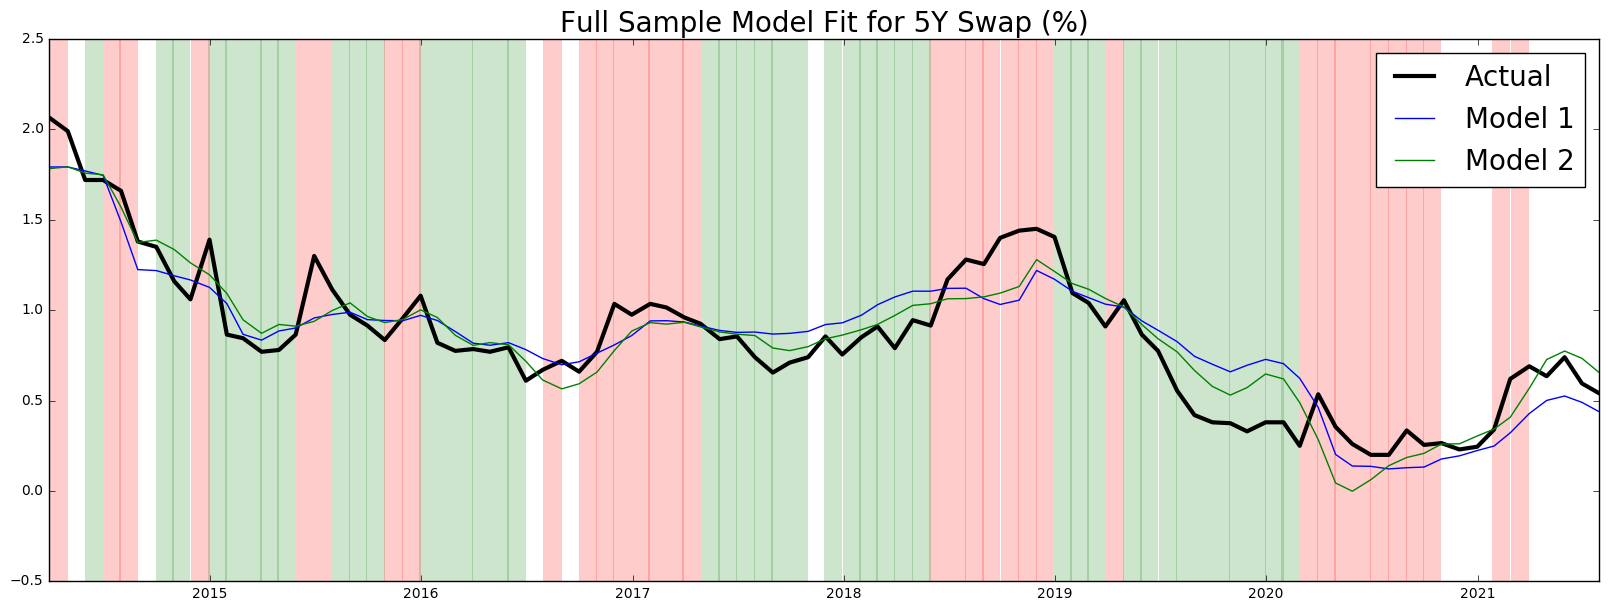

In [53]:
#collect model fits
results_israel = pd.DataFrame(results_israel_1['Actual 5Y Swap'])
results_israel['Actual 5Y Swap'] = results_israel_1['Actual 5Y Swap']
results_israel['Model 1'] = results_israel_1['Predictions']
results_israel['Model 2'] = results_israel_2['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_israel['Regime'] = np.zeros_like(results_israel['Actual 5Y Swap'])
for t in range(len(results_israel)):
    if results_israel['Model 1'][t] < results_israel['Actual 5Y Swap'][t]\
    and results_israel['Model 2'][t] < results_israel['Actual 5Y Swap'][t]:
        results_israel['Regime'][t] = -1
    
for t in range(len(results_israel)):
    if results_israel['Model 1'][t] > results_israel['Actual 5Y Swap'][t]\
    and results_israel['Model 2'][t] > results_israel['Actual 5Y Swap'][t]:
        results_israel['Regime'][t] = 1

results_israel['Dates'] = results_israel.index
results_israel['Dates'] = results_israel['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_israel['Year'] = results_israel['Dates'].dt.year
results_israel['Month'] = results_israel['Dates'].dt.month
results_israel['Day'] = results_israel['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_israel = results_israel.copy(deep = True)
regime_up_israel.drop(regime_up_israel[regime_up_israel.Regime < 1].index, inplace = True)

regime_down_israel = results_israel.copy(deep = True)
regime_down_israel.drop(regime_down_israel[regime_down_israel.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_israel['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_israel['Model 1'])
plt.plot(results_israel['Model 2'])

for t in range(1, len(regime_up_israel)):
    plt.axvspan(datetime(regime_up_israel['Year'][t], regime_up_israel['Month'][t], regime_up_israel['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_israel['Year'][t], regime_up_israel['Month'][t], regime_up_israel['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_israel)):
    plt.axvspan(datetime(regime_down_israel['Year'][t], regime_down_israel['Month'][t], regime_down_israel['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_israel['Year'][t], regime_down_israel['Month'][t], regime_down_israel['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## South Africa

In [54]:
#set dependent variables
Y = df_southafrica_sta['5Y Swap']
Y_y = df_southafrica_sta['5Y Swap y1']

Model 1
R-Squared = 0.429569265718
                           Coefficients
const                         -7.803970
Business Sentiment ma3 p1      0.160430
USD/LC Vol z                   0.257079
CT10 30D Vol z                -0.034884


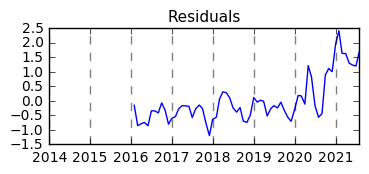

In [55]:
#model 1
X1 = df_southafrica_sta[['Business Sentiment ma3 p1',
                         'USD/LC Vol z',
                         'CT10 30D Vol z'
                   ]]
print('Model 1')
regress(Y, X1)

results_southafrica_1 = pd.read_excel('reg data dump.xlsx')
results_southafrica_1['Dates'] = pd.to_datetime(results_southafrica_1.Dates)
results_southafrica_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.701019227445
                Coefficients
const              -1.680232
EUR/LC Vol ma2     -0.046500
EM VIX z p1         0.013691
Rating ma2          0.939427


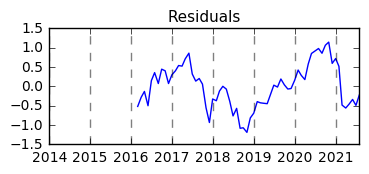

In [56]:
#model 2
X2 = df_southafrica_sta[['EUR/LC Vol ma2',
                         'EM VIX z p1',
                         'Rating ma2'
                   ]]
print('Model 2')
regress(Y, X2)

results_southafrica_2 = pd.read_excel('reg data dump.xlsx')
results_southafrica_2['Dates'] = pd.to_datetime(results_southafrica_2.Dates)
results_southafrica_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.449130840133
                          Coefficients
const                        13.846121
CT10 30D Vol z                0.008433
REER ma2                      0.060457
Unemployment Rate ma6 p1     -0.411740


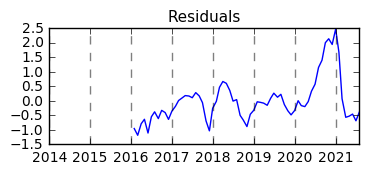

In [57]:
#model 3
X3 = df_southafrica_sta[['CT10 30D Vol z',
                         'REER ma2',
                         'Unemployment Rate ma6 p1'
                       ]]
print('Model 3')
regress(Y, X3)

results_southafrica_3 = pd.read_excel('reg data dump.xlsx')
results_southafrica_3['Dates'] = pd.to_datetime(results_southafrica_3.Dates)
results_southafrica_3.set_index('Dates', inplace=True)

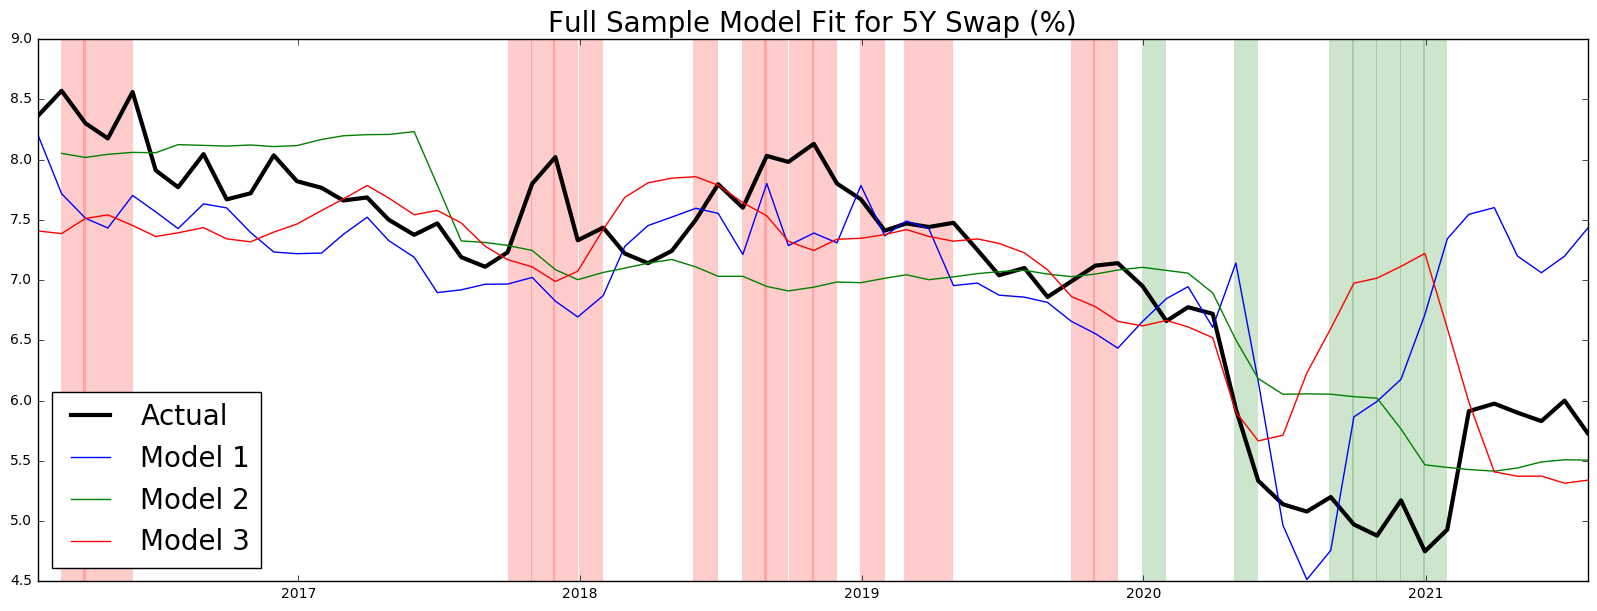

In [58]:
#collect model fits
results_southafrica = pd.DataFrame(results_southafrica_1['Actual 5Y Swap'])
results_southafrica['Actual 5Y Swap'] = results_southafrica_1['Actual 5Y Swap']
results_southafrica['Model 1'] = results_southafrica_1['Predictions']
results_southafrica['Model 2'] = results_southafrica_2['Predictions']
results_southafrica['Model 3'] = results_southafrica_3['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_southafrica['Regime'] = np.zeros_like(results_southafrica['Actual 5Y Swap'])
for t in range(len(results_southafrica)):
    if results_southafrica['Model 1'][t] < results_southafrica['Actual 5Y Swap'][t]\
    and results_southafrica['Model 2'][t] < results_southafrica['Actual 5Y Swap'][t]\
    and results_southafrica['Model 3'][t] < results_southafrica['Actual 5Y Swap'][t]:
        results_southafrica['Regime'][t] = -1
    
for t in range(len(results_southafrica)):
    if results_southafrica['Model 1'][t] > results_southafrica['Actual 5Y Swap'][t]\
    and results_southafrica['Model 2'][t] > results_southafrica['Actual 5Y Swap'][t]\
    and results_southafrica['Model 3'][t] > results_southafrica['Actual 5Y Swap'][t]:
        results_southafrica['Regime'][t] = 1

results_southafrica['Dates'] = results_southafrica.index
results_southafrica['Dates'] = results_southafrica['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_southafrica['Year'] = results_southafrica['Dates'].dt.year
results_southafrica['Month'] = results_southafrica['Dates'].dt.month
results_southafrica['Day'] = results_southafrica['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_southafrica = results_southafrica.copy(deep = True)
regime_up_southafrica.drop(regime_up_southafrica[regime_up_southafrica.Regime < 1].index, inplace = True)

regime_down_southafrica = results_southafrica.copy(deep = True)
regime_down_southafrica.drop(regime_down_southafrica[regime_down_southafrica.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_southafrica['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_southafrica['Model 1'])
plt.plot(results_southafrica['Model 2'])
plt.plot(results_southafrica['Model 3'])

for t in range(1, len(regime_up_southafrica)):
    plt.axvspan(datetime(regime_up_southafrica['Year'][t], regime_up_southafrica['Month'][t], regime_up_southafrica['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_southafrica['Year'][t], regime_up_southafrica['Month'][t], regime_up_southafrica['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_southafrica)):
    plt.axvspan(datetime(regime_down_southafrica['Year'][t], regime_down_southafrica['Month'][t], regime_down_southafrica['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_southafrica['Year'][t], regime_down_southafrica['Month'][t], regime_down_southafrica['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Russia

In [59]:
#set dependent variables
Y = df_russia_sta['5Y Swap']
Y_y = df_russia_sta['5Y Swap y1']

Model 1
R-Squared = 0.853692459476
                    Coefficients
const                   1.585105
USD/LC Vol ma3          0.265258
CT10 ma3                1.756077
CA Forecast 2Y ma3     -0.253250


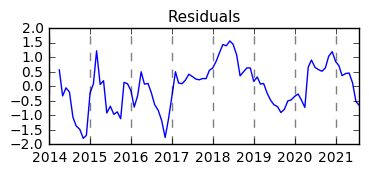

In [60]:
#model 1
X1 = df_russia_sta[['USD/LC Vol ma3',
                    'CT10 ma3',
                    'CA Forecast 2Y ma3'
                    ]]
print('Model 1')
regress(Y, X1)

results_russia_1 = pd.read_excel('reg data dump.xlsx')
results_russia_1['Dates'] = pd.to_datetime(results_russia_1.Dates)
results_russia_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.906821475922
                    Coefficients
const                   3.350283
1Y ma2                  0.789465
CA Forecast 2Y ma3     -0.356297


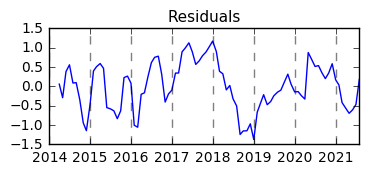

In [61]:
#model 2
X2 = df_russia_sta[['1Y ma2',
                    'CA Forecast 2Y ma3'
                    ]]
print('Model 2')
regress(Y, X2)

results_russia_2 = pd.read_excel('reg data dump.xlsx')
results_russia_2['Dates'] = pd.to_datetime(results_russia_2.Dates)
results_russia_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.838475793006
                 Coefficients
const               -0.624263
CPI Forecast 1Y      1.449094
CT10 ma3             1.178466


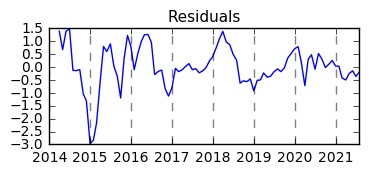

In [62]:
#model 3
X3 = df_russia_sta[['CPI Forecast 1Y',
                    'CT10 ma3'
                    ]]
print('Model 3')
regress(Y, X3)

results_russia_3 = pd.read_excel('reg data dump.xlsx')
results_russia_3['Dates'] = pd.to_datetime(results_russia_3.Dates)
results_russia_3.set_index('Dates', inplace=True)

Model 4
R-Squared = 0.819028720715
                              Coefficients
const                            18.939096
GDP Forecast 1Y ma2              -2.825382
CA Forecast 2Y ma6 p1            -0.905360
Industrial Production ma2 p1     -0.031515


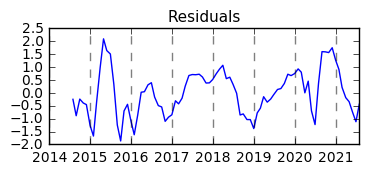

In [63]:
#model 4
X4 = df_russia_sta[['GDP Forecast 1Y ma2',
                    'CA Forecast 2Y ma6 p1',
                    'Industrial Production ma2 p1'
                    ]]
print('Model 4')
regress(Y, X4)

results_russia_4 = pd.read_excel('reg data dump.xlsx')
results_russia_4['Dates'] = pd.to_datetime(results_russia_4.Dates)
results_russia_4.set_index('Dates', inplace=True)

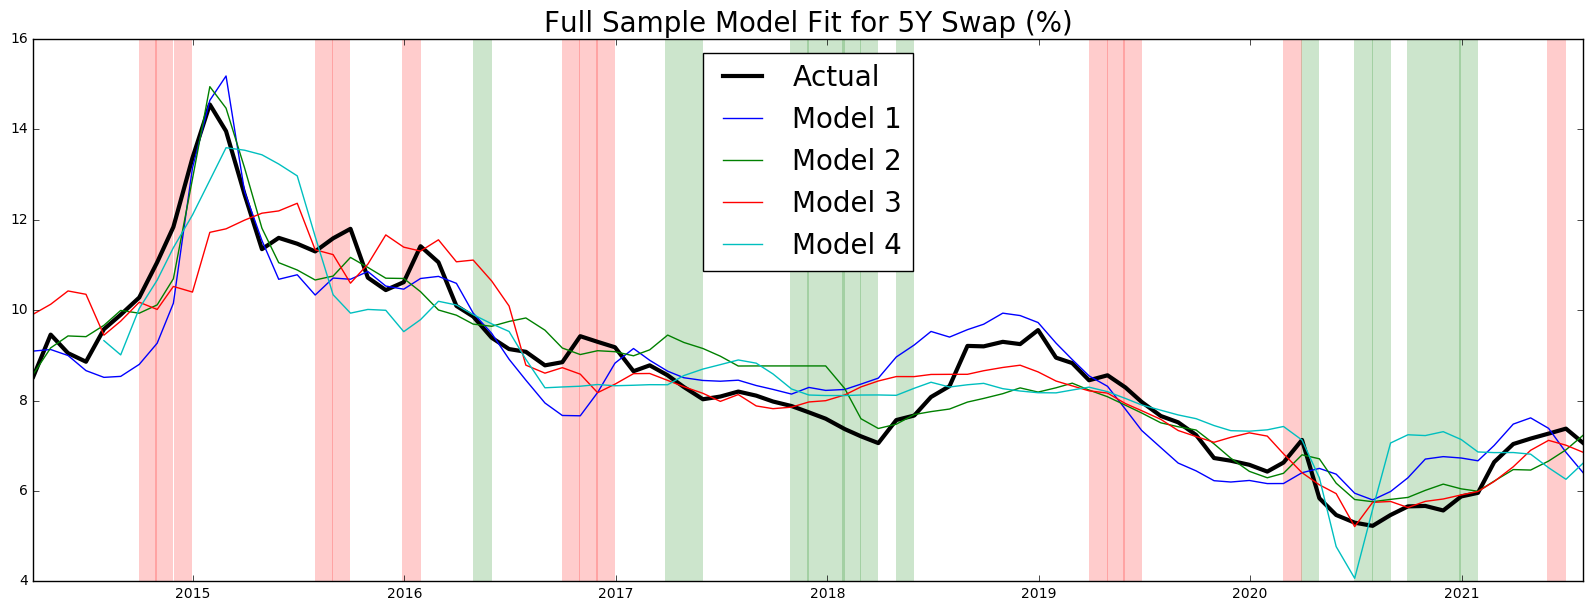

In [64]:
#collect model fits
results_russia = pd.DataFrame(results_russia_1['Actual 5Y Swap'])
results_russia['Actual 5Y Swap'] = results_russia_1['Actual 5Y Swap']
results_russia['Model 1'] = results_russia_1['Predictions']
results_russia['Model 2'] = results_russia_2['Predictions']
results_russia['Model 3'] = results_russia_3['Predictions']
results_russia['Model 4'] = results_russia_4['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_russia['Regime'] = np.zeros_like(results_russia['Actual 5Y Swap'])
for t in range(len(results_russia)):
    if results_russia['Model 1'][t] < results_russia['Actual 5Y Swap'][t]\
    and results_russia['Model 2'][t] < results_russia['Actual 5Y Swap'][t]\
    and results_russia['Model 3'][t] < results_russia['Actual 5Y Swap'][t]\
    and results_russia['Model 4'][t] < results_russia['Actual 5Y Swap'][t]:
        results_russia['Regime'][t] = -1
    
for t in range(len(results_russia)):
    if results_russia['Model 1'][t] > results_russia['Actual 5Y Swap'][t]\
    and results_russia['Model 2'][t] > results_russia['Actual 5Y Swap'][t]\
    and results_russia['Model 3'][t] > results_russia['Actual 5Y Swap'][t]\
    and results_russia['Model 4'][t] > results_russia['Actual 5Y Swap'][t]:
        results_russia['Regime'][t] = 1

results_russia['Dates'] = results_russia.index
results_russia['Dates'] = results_russia['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_russia['Year'] = results_russia['Dates'].dt.year
results_russia['Month'] = results_russia['Dates'].dt.month
results_russia['Day'] = results_russia['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_russia = results_russia.copy(deep = True)
regime_up_russia.drop(regime_up_russia[regime_up_russia.Regime < 1].index, inplace = True)

regime_down_russia = results_russia.copy(deep = True)
regime_down_russia.drop(regime_down_russia[regime_down_russia.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_russia['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_russia['Model 1'])
plt.plot(results_russia['Model 2'])
plt.plot(results_russia['Model 3'])
plt.plot(results_russia['Model 4'])

for t in range(1, len(regime_up_russia)):
    plt.axvspan(datetime(regime_up_russia['Year'][t], regime_up_russia['Month'][t], regime_up_russia['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_russia['Year'][t], regime_up_russia['Month'][t], regime_up_russia['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_russia)):
    plt.axvspan(datetime(regime_down_russia['Year'][t], regime_down_russia['Month'][t], regime_down_russia['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_russia['Year'][t], regime_down_russia['Month'][t], regime_down_russia['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3', 'Model 4'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Turkey

In [65]:
#set dependent variables
Y = df_turkey_sta['5Y Swap']
Y_y = df_turkey_sta['5Y Swap y1']

Model 1
R-Squared = 0.844494510997
                  Coefficients
const                 4.135871
1Y y1                 0.698901
EQ Index YoY ma2     -0.337304


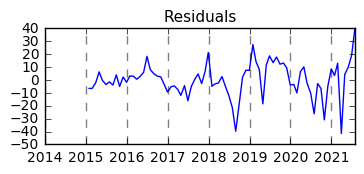

In [66]:
#model 1
X1 = df_turkey_sta[['1Y y1',
                    'EQ Index YoY ma2'
                    ]]
print('Model 1')
regress_y(df_turkey_sta, Y_y, X1)

results_turkey_1 = pd.read_excel('reg data dump.xlsx')
results_turkey_1['Dates'] = pd.to_datetime(results_turkey_1.Dates)
results_turkey_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.844424099747
                            Coefficients
const                           0.784637
1Y ma2                          0.708852
Gov Budget Forecast 1Y ma3     -1.077838


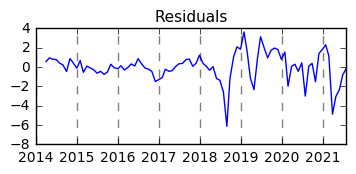

In [67]:
#model 2
X2 = df_turkey_sta[['1Y ma2',
                    'Gov Budget Forecast 1Y ma3'
                    ]]
print('Model 2')
regress(Y, X2)

results_turkey_2 = pd.read_excel('reg data dump.xlsx')
results_turkey_2['Dates'] = pd.to_datetime(results_turkey_2.Dates)
results_turkey_2.set_index('Dates', inplace=True)

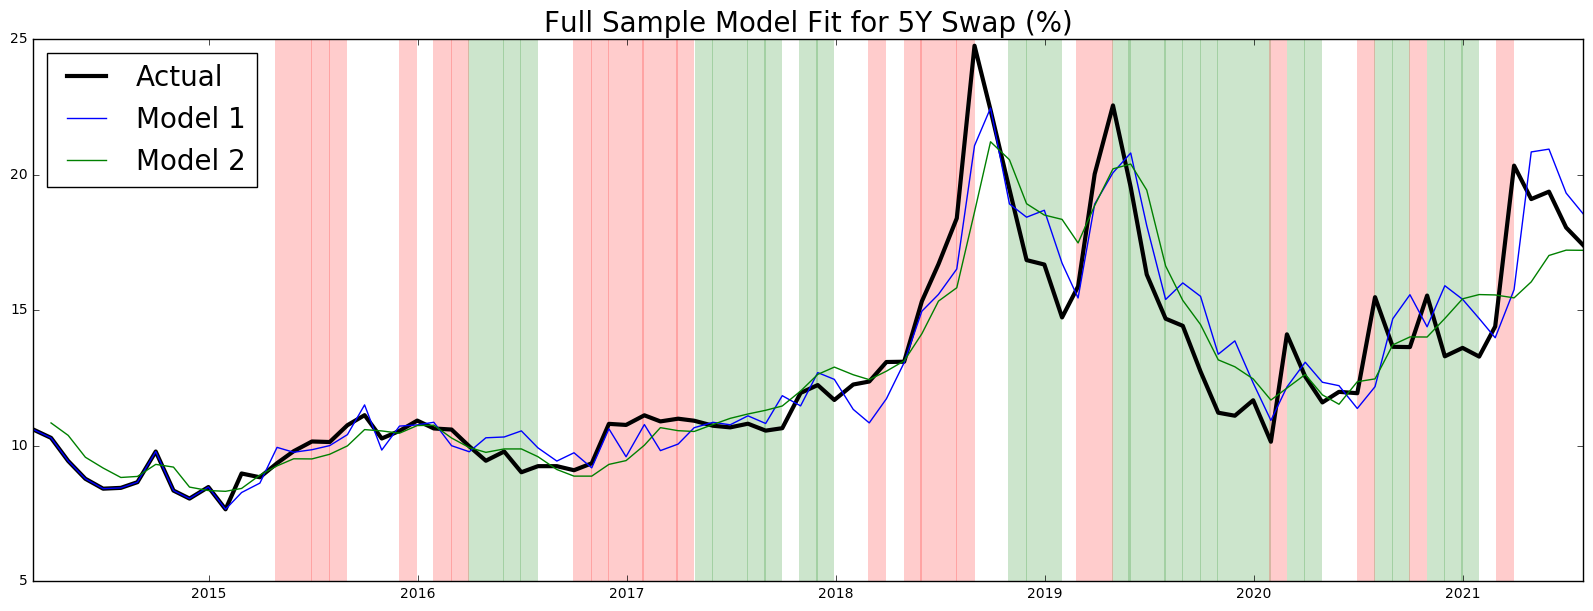

In [68]:
#collect model fits
results_turkey = pd.DataFrame(results_turkey_1['Actual 5Y Swap'])
results_turkey['Actual 5Y Swap'] = results_turkey_1['Actual 5Y Swap']
results_turkey['Model 1'] = results_turkey_1['Predictions']
results_turkey['Model 2'] = results_turkey_2['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_turkey['Regime'] = np.zeros_like(results_turkey['Actual 5Y Swap'])
for t in range(len(results_turkey)):
    if results_turkey['Model 1'][t] < results_turkey['Actual 5Y Swap'][t]\
    and results_turkey['Model 2'][t] < results_turkey['Actual 5Y Swap'][t]:
        results_turkey['Regime'][t] = -1
    
for t in range(len(results_turkey)):
    if results_turkey['Model 1'][t] > results_turkey['Actual 5Y Swap'][t]\
    and results_turkey['Model 2'][t] > results_turkey['Actual 5Y Swap'][t]:
        results_turkey['Regime'][t] = 1

results_turkey['Dates'] = results_turkey.index
results_turkey['Dates'] = results_turkey['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_turkey['Year'] = results_turkey['Dates'].dt.year
results_turkey['Month'] = results_turkey['Dates'].dt.month
results_turkey['Day'] = results_turkey['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_turkey = results_turkey.copy(deep = True)
regime_up_turkey.drop(regime_up_turkey[regime_up_turkey.Regime < 1].index, inplace = True)

regime_down_turkey = results_turkey.copy(deep = True)
regime_down_turkey.drop(regime_down_turkey[regime_down_turkey.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_turkey['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_turkey['Model 1'])
plt.plot(results_turkey['Model 2'])

for t in range(1, len(regime_up_turkey)):
    plt.axvspan(datetime(regime_up_turkey['Year'][t], regime_up_turkey['Month'][t], regime_up_turkey['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_turkey['Year'][t], regime_up_turkey['Month'][t], regime_up_turkey['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_turkey)):
    plt.axvspan(datetime(regime_down_turkey['Year'][t], regime_down_turkey['Month'][t], regime_down_turkey['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_turkey['Year'][t], regime_down_turkey['Month'][t], regime_down_turkey['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Indonesia

In [69]:
#set dependent variables
Y = df_indonesia_sta['5Y Swap']
Y_y = df_indonesia_sta['5Y Swap y1']

Model 1
R-Squared = 0.412509789416
                            Coefficients
const                         -36.406404
Reserves Import Cover ma12      4.442734
CPI Forecast 1Y y1              0.933794
REER y1 p1                     -1.273739


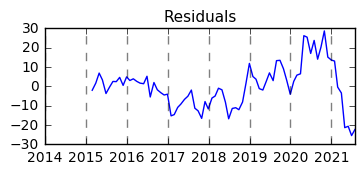

In [70]:
#model 1
X1 = df_indonesia_sta[['Reserves Import Cover ma12',
                     'CPI Forecast 1Y y1',
                     'REER y1 p1'
                        ]]
print('Model 1')
regress_y(df_indonesia_sta, Y_y, X1)

results_indonesia_1 = pd.read_excel('reg data dump.xlsx')
results_indonesia_1['Dates'] = pd.to_datetime(results_indonesia_1.Dates)
results_indonesia_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.627879024104
                  Coefficients
const                 5.879304
1Y y1                 0.033622
MOVE ma3 p1           0.004818
EQ Index YoY ma2      0.028607


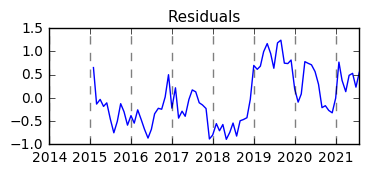

In [71]:
#model 2
X2 = df_indonesia_sta[['1Y y1',
                     'MOVE ma3 p1',
                     'EQ Index YoY ma2'
                        ]]
print('Model 2')
regress(Y, X2)

results_indonesia_2 = pd.read_excel('reg data dump.xlsx')
results_indonesia_2['Dates'] = pd.to_datetime(results_indonesia_2.Dates)
results_indonesia_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.546207828837
                                  Coefficients
const                                11.674858
REER ma12                            -0.059136
Gov Effectiveness Monthly ma3 p1     -2.601925
Gov Budget Forecast 1Y y1 p1         -0.010267
EQ Index YoY ma2                      0.016669


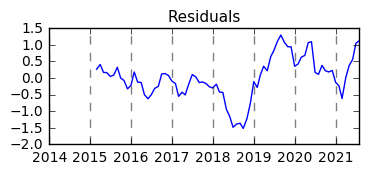

In [72]:
#model 3
X3 = df_indonesia_sta[['REER ma12',
                     'Gov Effectiveness Monthly ma3 p1',
                     'Gov Budget Forecast 1Y y1 p1',
                     'EQ Index YoY ma2'
                        ]]
print('Model 3')
regress(Y, X3)

results_indonesia_3 = pd.read_excel('reg data dump.xlsx')
results_indonesia_3['Dates'] = pd.to_datetime(results_indonesia_3.Dates)
results_indonesia_3.set_index('Dates', inplace=True)

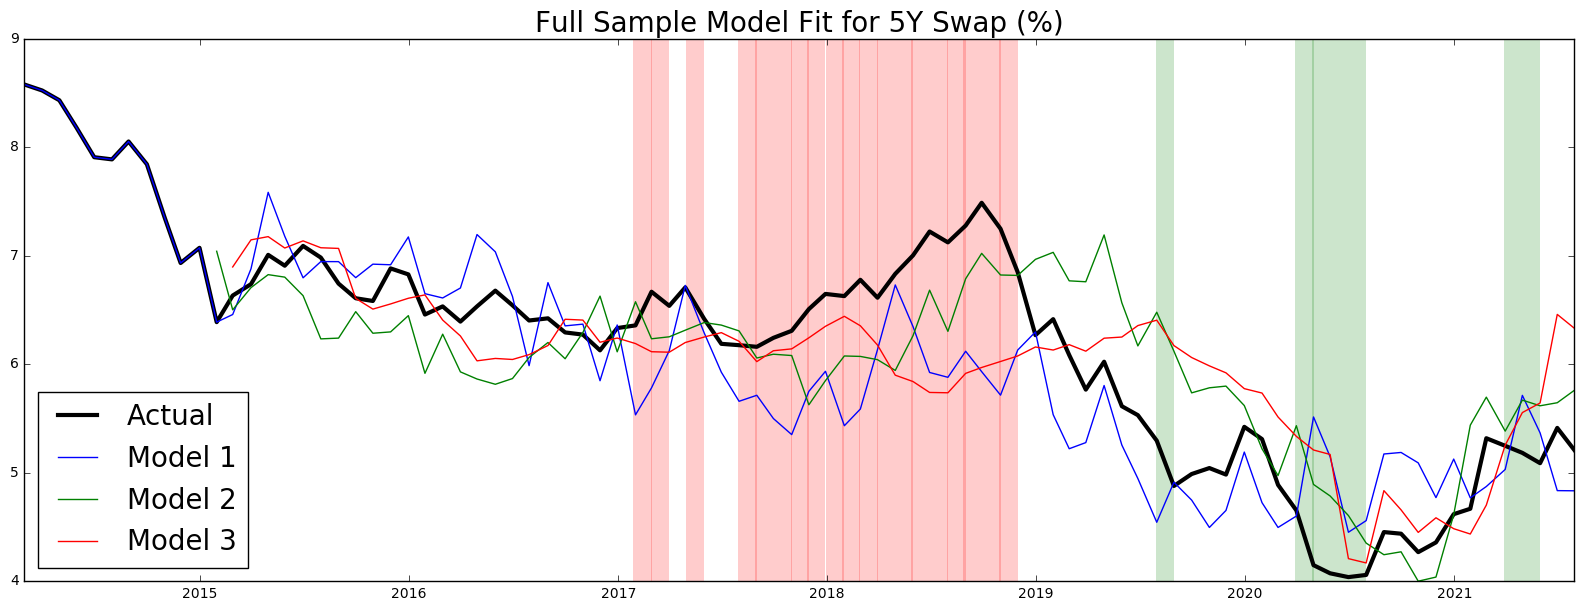

In [73]:
#collect model fits
results_indonesia = pd.DataFrame(results_indonesia_1['Actual 5Y Swap'])
results_indonesia['Actual 5Y Swap'] = results_indonesia_1['Actual 5Y Swap']
results_indonesia['Model 1'] = results_indonesia_1['Predictions']
results_indonesia['Model 2'] = results_indonesia_2['Predictions']
results_indonesia['Model 3'] = results_indonesia_3['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_indonesia['Regime'] = np.zeros_like(results_indonesia['Actual 5Y Swap'])
for t in range(len(results_indonesia)):
    if results_indonesia['Model 1'][t] < results_indonesia['Actual 5Y Swap'][t]\
    and results_indonesia['Model 2'][t] < results_indonesia['Actual 5Y Swap'][t]\
    and results_indonesia['Model 3'][t] < results_indonesia['Actual 5Y Swap'][t]:
        results_indonesia['Regime'][t] = -1
    
for t in range(len(results_indonesia)):
    if results_indonesia['Model 1'][t] > results_indonesia['Actual 5Y Swap'][t]\
    and results_indonesia['Model 2'][t] > results_indonesia['Actual 5Y Swap'][t]\
    and results_indonesia['Model 3'][t] > results_indonesia['Actual 5Y Swap'][t]:
        results_indonesia['Regime'][t] = 1

results_indonesia['Dates'] = results_indonesia.index
results_indonesia['Dates'] = results_indonesia['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_indonesia['Year'] = results_indonesia['Dates'].dt.year
results_indonesia['Month'] = results_indonesia['Dates'].dt.month
results_indonesia['Day'] = results_indonesia['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_indonesia = results_indonesia.copy(deep = True)
regime_up_indonesia.drop(regime_up_indonesia[regime_up_indonesia.Regime < 1].index, inplace = True)

regime_down_indonesia = results_indonesia.copy(deep = True)
regime_down_indonesia.drop(regime_down_indonesia[regime_down_indonesia.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_indonesia['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_indonesia['Model 1'])
plt.plot(results_indonesia['Model 2'])
plt.plot(results_indonesia['Model 3'])

for t in range(1, len(regime_up_indonesia)):
    plt.axvspan(datetime(regime_up_indonesia['Year'][t], regime_up_indonesia['Month'][t], regime_up_indonesia['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_indonesia['Year'][t], regime_up_indonesia['Month'][t], regime_up_indonesia['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_indonesia)):
    plt.axvspan(datetime(regime_down_indonesia['Year'][t], regime_down_indonesia['Month'][t], regime_down_indonesia['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_indonesia['Year'][t], regime_down_indonesia['Month'][t], regime_down_indonesia['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Thailand

In [74]:
#set dependent variables
Y = df_thailand_sta['5Y Swap']
Y_y = df_thailand_sta['5Y Swap y1']

Model 1
R-Squared = 0.766545134093
                        Coefficients
const                      14.314013
REER ma12                  -0.111353
Trade Bal as % GDP ma3     -0.099248
CA Forecast 1Y ma2         -0.042891


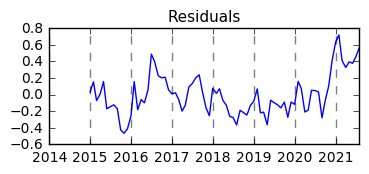

In [75]:
#model 1
X1 = df_thailand_sta[['REER ma12',
                      'Trade Bal as % GDP ma3',
                      'CA Forecast 1Y ma2'
                        ]]
print('Model 1')
regress(Y, X1)

results_thailand_1 = pd.read_excel('reg data dump.xlsx')
results_thailand_1['Dates'] = pd.to_datetime(results_thailand_1.Dates)
results_thailand_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.769486424321
                        Coefficients
const                       0.673457
CPI Forecast 1Y ma2         0.875799
Trade Bal as % GDP ma3     -0.069108


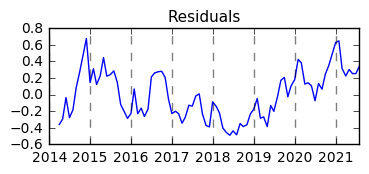

In [76]:
#model 2
X2 = df_thailand_sta[['CPI Forecast 1Y ma2',
                      'Trade Bal as % GDP ma3'
                        ]]
print('Model 2')
regress(Y, X2)

results_thailand_2 = pd.read_excel('reg data dump.xlsx')
results_thailand_2['Dates'] = pd.to_datetime(results_thailand_2.Dates)
results_thailand_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.735980154647
                    Coefficients
const                   0.953816
USD Swap 10Y ma2        0.721072
CA Forecast 1Y ma2     -0.086612


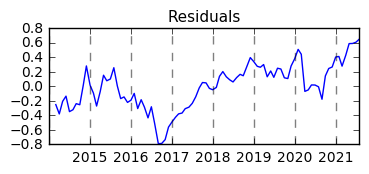

In [79]:
#model 3
X3 = df_thailand_sta[['USD Swap 10Y ma2',
                      'CA Forecast 1Y ma2'
                        ]]
print('Model 3')
regress(Y, X3)

results_thailand_3 = pd.read_excel('reg data dump.xlsx')
results_thailand_3['Dates'] = pd.to_datetime(results_thailand_3.Dates)
results_thailand_3.set_index('Dates', inplace=True)

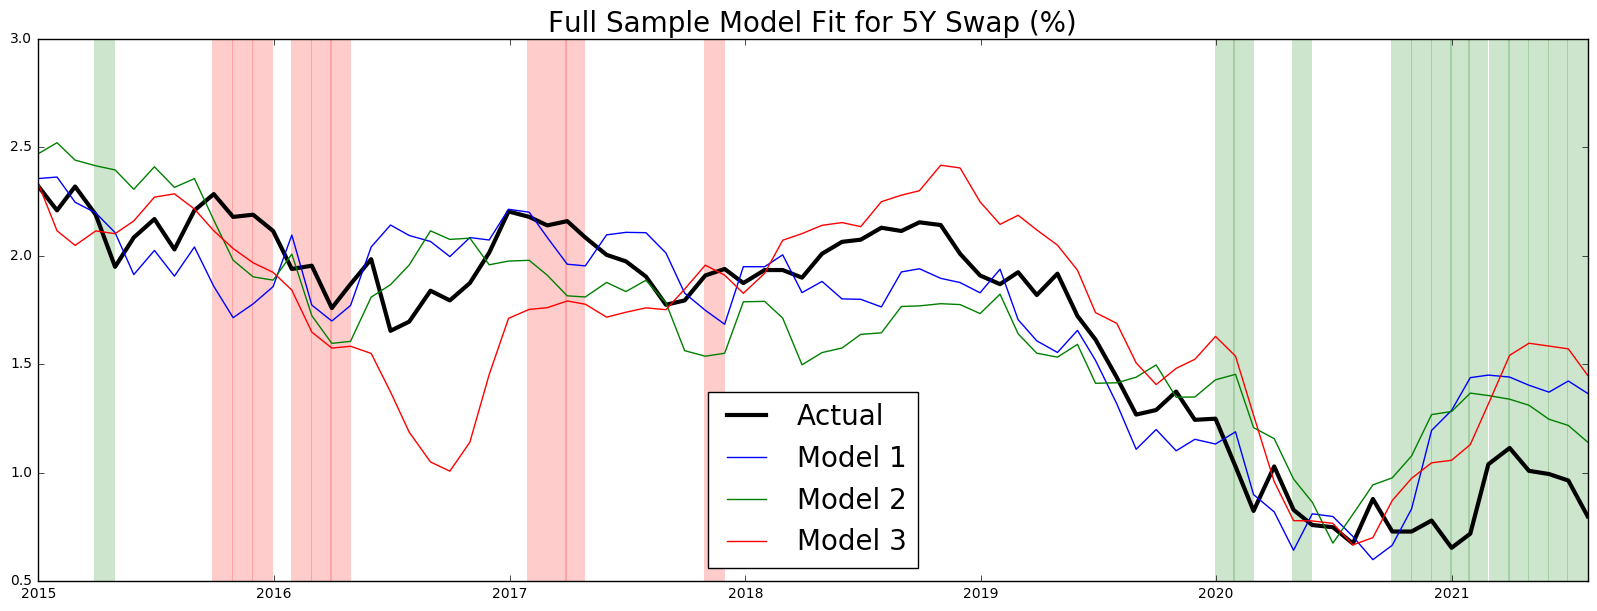

In [80]:
#collect model fits
results_thailand = pd.DataFrame(results_thailand_1['Actual 5Y Swap'])
results_thailand['Actual 5Y Swap'] = results_thailand_1['Actual 5Y Swap']
results_thailand['Model 1'] = results_thailand_1['Predictions']
results_thailand['Model 2'] = results_thailand_2['Predictions']
results_thailand['Model 3'] = results_thailand_3['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_thailand['Regime'] = np.zeros_like(results_thailand['Actual 5Y Swap'])
for t in range(len(results_thailand)):
    if results_thailand['Model 1'][t] < results_thailand['Actual 5Y Swap'][t]\
    and results_thailand['Model 2'][t] < results_thailand['Actual 5Y Swap'][t]\
    and results_thailand['Model 3'][t] < results_thailand['Actual 5Y Swap'][t]:
        results_thailand['Regime'][t] = -1
    
for t in range(len(results_thailand)):
    if results_thailand['Model 1'][t] > results_thailand['Actual 5Y Swap'][t]\
    and results_thailand['Model 2'][t] > results_thailand['Actual 5Y Swap'][t]\
    and results_thailand['Model 3'][t] > results_thailand['Actual 5Y Swap'][t]:
        results_thailand['Regime'][t] = 1

results_thailand['Dates'] = results_thailand.index
results_thailand['Dates'] = results_thailand['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_thailand['Year'] = results_thailand['Dates'].dt.year
results_thailand['Month'] = results_thailand['Dates'].dt.month
results_thailand['Day'] = results_thailand['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_thailand = results_thailand.copy(deep = True)
regime_up_thailand.drop(regime_up_thailand[regime_up_thailand.Regime < 1].index, inplace = True)

regime_down_thailand = results_thailand.copy(deep = True)
regime_down_thailand.drop(regime_down_thailand[regime_down_thailand.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_thailand['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_thailand['Model 1'])
plt.plot(results_thailand['Model 2'])
plt.plot(results_thailand['Model 3'])

for t in range(1, len(regime_up_thailand)):
    plt.axvspan(datetime(regime_up_thailand['Year'][t], regime_up_thailand['Month'][t], regime_up_thailand['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_thailand['Year'][t], regime_up_thailand['Month'][t], regime_up_thailand['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_thailand)):
    plt.axvspan(datetime(regime_down_thailand['Year'][t], regime_down_thailand['Month'][t], regime_down_thailand['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_thailand['Year'][t], regime_down_thailand['Month'][t], regime_down_thailand['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## India

In [81]:
#set dependent variables
Y = df_india_sta['5Y Swap']
Y_y = df_india_sta['5Y Swap y1']

Model 1
R-Squared = 0.64759074884
                            Coefficients
const                           2.525023
Trade Bal as % GDP SA ma12     -0.401932
CPI Forecast 1Y                 0.909320


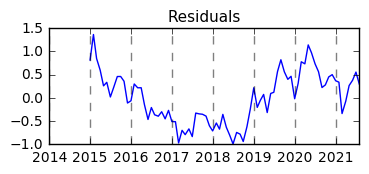

In [82]:
#model 1
X1 = df_india_sta[['Trade Bal as % GDP SA ma12',
                   'CPI Forecast 1Y'
                   ]]
print('Model 1')
regress(Y, X1)

results_india_1 = pd.read_excel('reg data dump.xlsx')
results_india_1['Dates'] = pd.to_datetime(results_india_1.Dates)
results_india_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.782362331574
                           Coefficients
const                         20.657175
REER                          -0.121830
Reserves Import Cover ma2     -0.221399


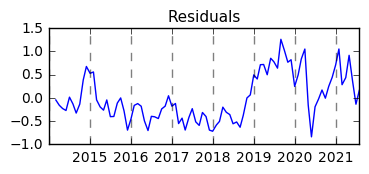

In [83]:
#model 2
X2 = df_india_sta[['REER',
                   'Reserves Import Cover ma2'
                   ]]
print('Model 2')
regress(Y, X2)

results_india_2 = pd.read_excel('reg data dump.xlsx')
results_india_2['Dates'] = pd.to_datetime(results_india_2.Dates)
results_india_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.67331715847
                           Coefficients
const                         16.014417
REER                          -0.098463
Gov Budget Forecast 2Y y1     -0.031436


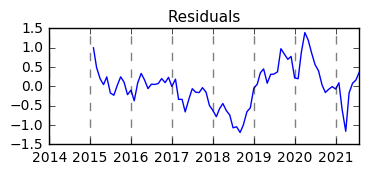

In [84]:
#model 3
X3 = df_india_sta[['REER',
                   'Gov Budget Forecast 2Y y1'
                   ]]
print('Model 3')
regress(Y, X3)

results_india_3 = pd.read_excel('reg data dump.xlsx')
results_india_3['Dates'] = pd.to_datetime(results_india_3.Dates)
results_india_3.set_index('Dates', inplace=True)

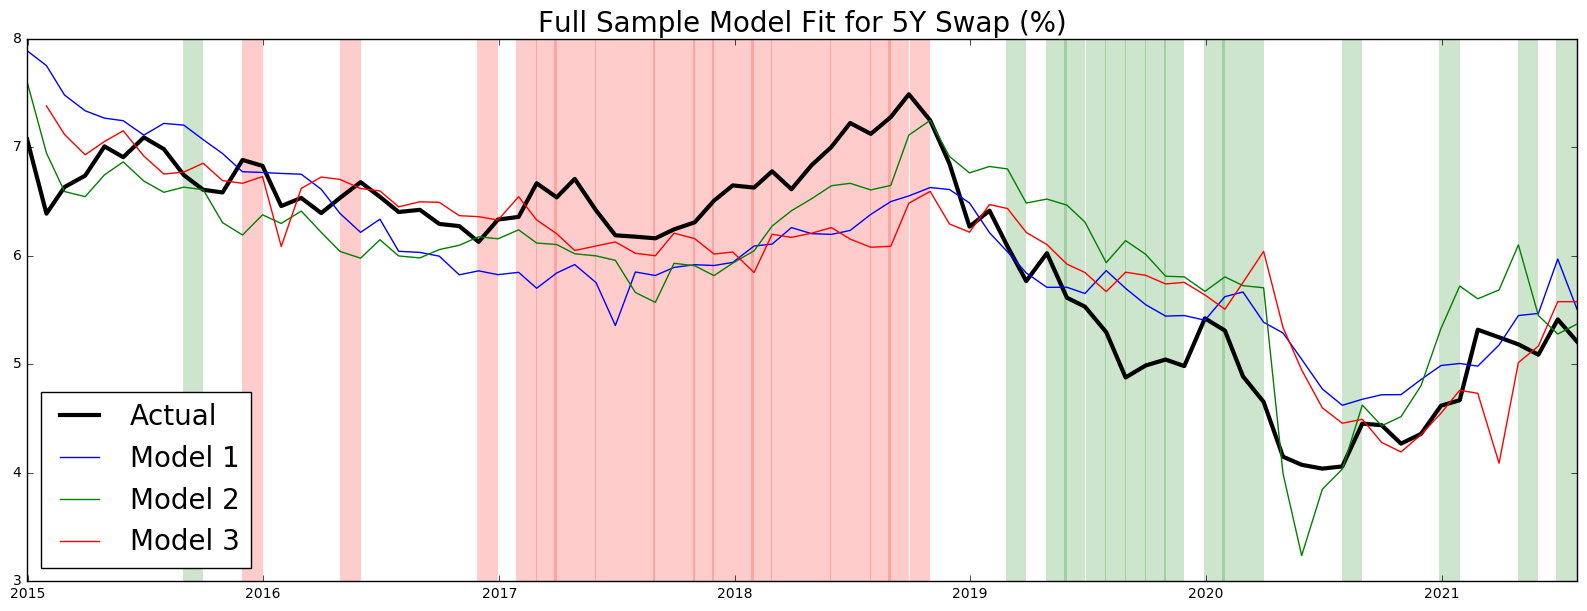

In [85]:
#collect model fits
results_india = pd.DataFrame(results_india_1['Actual 5Y Swap'])
results_india['Actual 5Y Swap'] = results_india_1['Actual 5Y Swap']
results_india['Model 1'] = results_india_1['Predictions']
results_india['Model 2'] = results_india_2['Predictions']
results_india['Model 3'] = results_india_3['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_india['Regime'] = np.zeros_like(results_india['Actual 5Y Swap'])
for t in range(len(results_india)):
    if results_india['Model 1'][t] < results_india['Actual 5Y Swap'][t]\
    and results_india['Model 2'][t] < results_india['Actual 5Y Swap'][t]\
    and results_india['Model 3'][t] < results_india['Actual 5Y Swap'][t]:
        results_india['Regime'][t] = -1
    
for t in range(len(results_india)):
    if results_india['Model 1'][t] > results_india['Actual 5Y Swap'][t]\
    and results_india['Model 2'][t] > results_india['Actual 5Y Swap'][t]\
    and results_india['Model 3'][t] > results_india['Actual 5Y Swap'][t]:
        results_india['Regime'][t] = 1

results_india['Dates'] = results_india.index
results_india['Dates'] = results_india['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_india['Year'] = results_india['Dates'].dt.year
results_india['Month'] = results_india['Dates'].dt.month
results_india['Day'] = results_india['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_india = results_india.copy(deep = True)
regime_up_india.drop(regime_up_india[regime_up_india.Regime < 1].index, inplace = True)

regime_down_india = results_india.copy(deep = True)
regime_down_india.drop(regime_down_india[regime_down_india.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_india['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_india['Model 1'])
plt.plot(results_india['Model 2'])
plt.plot(results_india['Model 3'])

for t in range(1, len(regime_up_india)):
    plt.axvspan(datetime(regime_up_india['Year'][t], regime_up_india['Month'][t], regime_up_india['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_india['Year'][t], regime_up_india['Month'][t], regime_up_india['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_india)):
    plt.axvspan(datetime(regime_down_india['Year'][t], regime_down_india['Month'][t], regime_down_india['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_india['Year'][t], regime_down_india['Month'][t], regime_down_india['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

***

## Korea

In [86]:
#set dependent variables
Y = df_korea_sta['5Y Swap']
Y_y = df_korea_sta['5Y Swap y1']

Model 1
R-Squared = 0.749184349699
                     Coefficients
const                   -0.466947
CPI Forecast 2Y ma3      1.106006
1Y y1                    0.008610


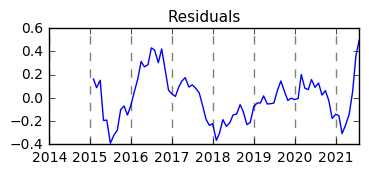

In [87]:
#model 1
X1 = df_korea_sta[['CPI Forecast 2Y ma3',
                   '1Y y1'
                   ]]
print('Model 1')
regress(Y, X1)

results_korea_1 = pd.read_excel('reg data dump.xlsx')
results_korea_1['Dates'] = pd.to_datetime(results_korea_1.Dates)
results_korea_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.711921779871
                           Coefficients
const                          4.816496
Reserves Import Cover ma3     -0.327749
External Debt as % GDP y1     -0.028906


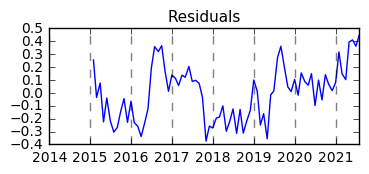

In [88]:
#model 2
X2 = df_korea_sta[['Reserves Import Cover ma3',
                   'External Debt as % GDP y1'
                   ]]
print('Model 2')
regress(Y, X2)

results_korea_2 = pd.read_excel('reg data dump.xlsx')
results_korea_2['Dates'] = pd.to_datetime(results_korea_2.Dates)
results_korea_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.798835381444
            Coefficients
const          10.244256
CT10 ma2        0.558396
Rating ma2     -0.554450


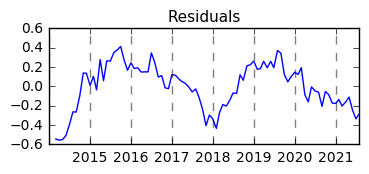

In [89]:
#model 3
X3 = df_korea_sta[['CT10 ma2',
                   'Rating ma2'
                   ]]
print('Model 3')
regress(Y, X3)

results_korea_3 = pd.read_excel('reg data dump.xlsx')
results_korea_3['Dates'] = pd.to_datetime(results_korea_3.Dates)
results_korea_3.set_index('Dates', inplace=True)

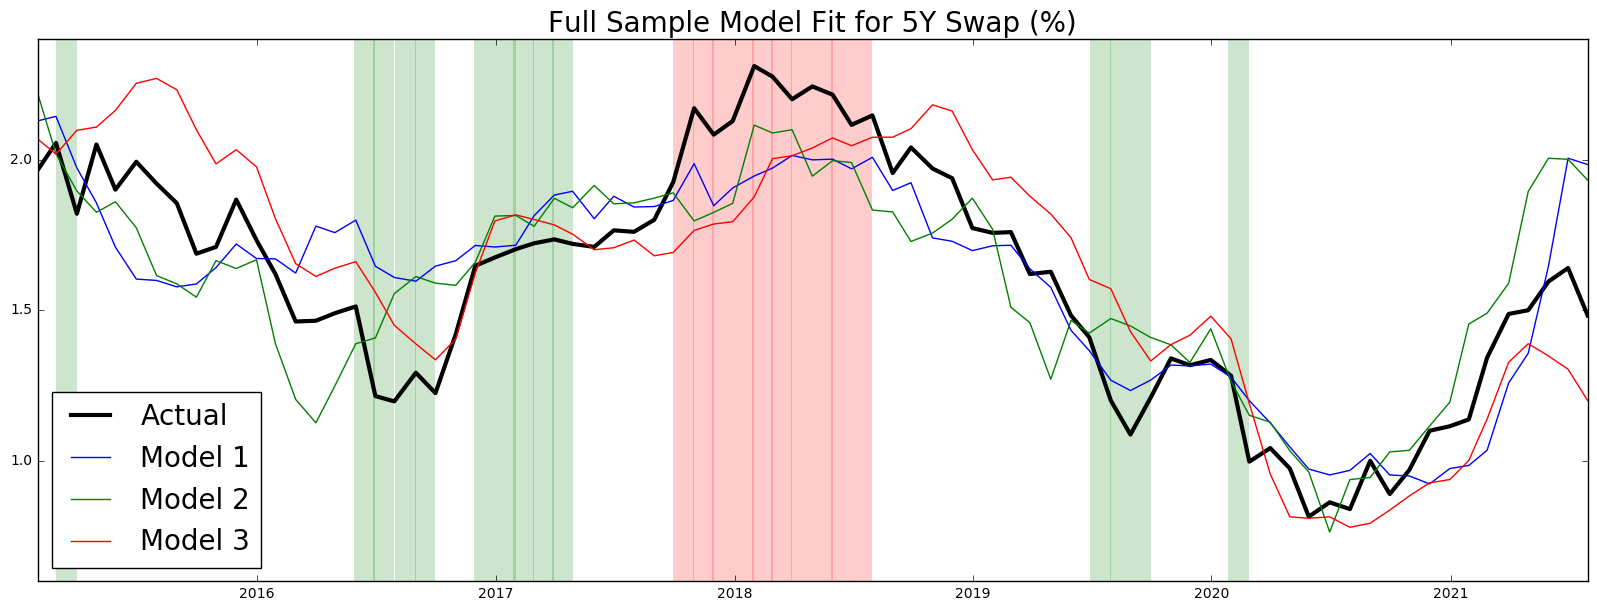

In [90]:
#collect model fits
results_korea = pd.DataFrame(results_korea_1['Actual 5Y Swap'])
results_korea['Actual 5Y Swap'] = results_korea_1['Actual 5Y Swap']
results_korea['Model 1'] = results_korea_1['Predictions']
results_korea['Model 2'] = results_korea_2['Predictions']
results_korea['Model 3'] = results_korea_3['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_korea['Regime'] = np.zeros_like(results_korea['Actual 5Y Swap'])
for t in range(len(results_korea)):
    if results_korea['Model 1'][t] < results_korea['Actual 5Y Swap'][t]\
    and results_korea['Model 2'][t] < results_korea['Actual 5Y Swap'][t]\
    and results_korea['Model 3'][t] < results_korea['Actual 5Y Swap'][t]:
        results_korea['Regime'][t] = -1
    
for t in range(len(results_korea)):
    if results_korea['Model 1'][t] > results_korea['Actual 5Y Swap'][t]\
    and results_korea['Model 2'][t] > results_korea['Actual 5Y Swap'][t]\
    and results_korea['Model 3'][t] > results_korea['Actual 5Y Swap'][t]:
        results_korea['Regime'][t] = 1

results_korea['Dates'] = results_korea.index
results_korea['Dates'] = results_korea['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_korea['Year'] = results_korea['Dates'].dt.year
results_korea['Month'] = results_korea['Dates'].dt.month
results_korea['Day'] = results_korea['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_korea = results_korea.copy(deep = True)
regime_up_korea.drop(regime_up_korea[regime_up_korea.Regime < 1].index, inplace = True)

regime_down_korea = results_korea.copy(deep = True)
regime_down_korea.drop(regime_down_korea[regime_down_korea.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_korea['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_korea['Model 1'])
plt.plot(results_korea['Model 2'])
plt.plot(results_korea['Model 3'])

for t in range(1, len(regime_up_korea)):
    plt.axvspan(datetime(regime_up_korea['Year'][t], regime_up_korea['Month'][t], regime_up_korea['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_korea['Year'][t], regime_up_korea['Month'][t], regime_up_korea['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_korea)):
    plt.axvspan(datetime(regime_down_korea['Year'][t], regime_down_korea['Month'][t], regime_down_korea['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_korea['Year'][t], regime_down_korea['Month'][t], regime_down_korea['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## China

In [91]:
#set dependent variables
Y = df_china_sta['5Y Swap']
Y_y = df_china_sta['5Y Swap y1']

Model 1
R-Squared = 0.521958986693
                           Coefficients
const                         -1.267582
Policy Rate                    0.457104
Rating y1                     -0.235942
Gov Budget Forecast 2Y y1     -0.002752
EUR/LC ma2                     0.291155


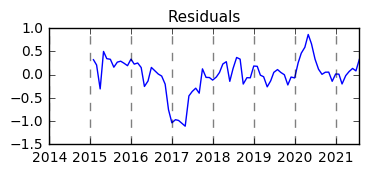

In [92]:
#model 1
X1 = df_china_sta[['Policy Rate',
                   'Rating y1',
                   'Gov Budget Forecast 2Y y1',
                   'EUR/LC ma2'
                   ]]
print('Model 1')
regress(Y, X1)

results_china_1 = pd.read_excel('reg data dump.xlsx')
results_china_1['Dates'] = pd.to_datetime(results_china_1.Dates)
results_china_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.460044332368
                 Coefficients
const                0.394956
CPI Forecast 1Y      0.781325
CT10 ma3             0.446812


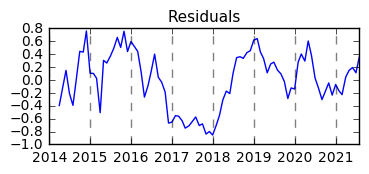

In [93]:
#model 2
X2 = df_china_sta[['CPI Forecast 1Y',
                   'CT10 ma3'
                   ]]
print('Model 2')
regress(Y, X2)

results_china_2 = pd.read_excel('reg data dump.xlsx')
results_china_2['Dates'] = pd.to_datetime(results_china_2.Dates)
results_china_2.set_index('Dates', inplace=True)

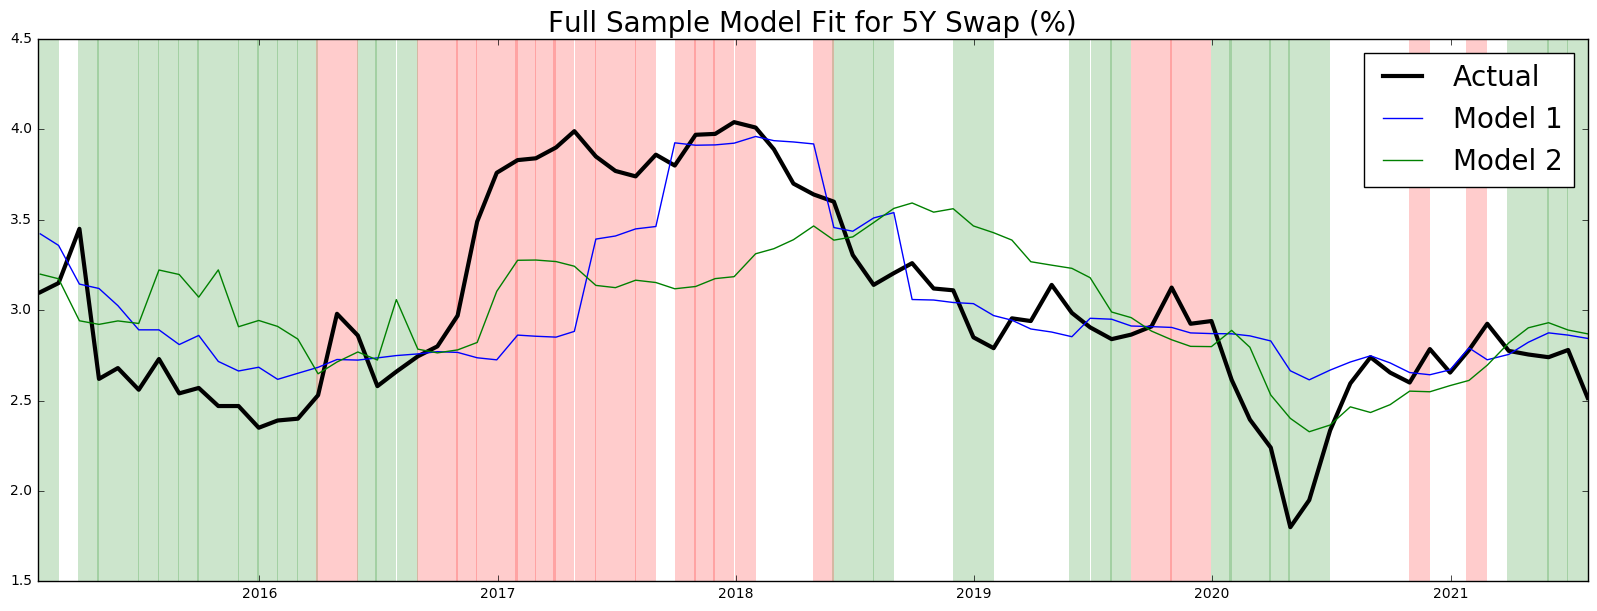

In [94]:
#collect model fits
results_china = pd.DataFrame(results_china_1['Actual 5Y Swap'])
results_china['Actual 5Y Swap'] = results_china_1['Actual 5Y Swap']
results_china['Model 1'] = results_china_1['Predictions']
results_china['Model 2'] = results_china_2['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_china['Regime'] = np.zeros_like(results_china['Actual 5Y Swap'])
for t in range(len(results_china)):
    if results_china['Model 1'][t] < results_china['Actual 5Y Swap'][t]\
    and results_china['Model 2'][t] < results_china['Actual 5Y Swap'][t]:
        results_china['Regime'][t] = -1
    
for t in range(len(results_china)):
    if results_china['Model 1'][t] > results_china['Actual 5Y Swap'][t]\
    and results_china['Model 2'][t] > results_china['Actual 5Y Swap'][t]:
        results_china['Regime'][t] = 1

results_china['Dates'] = results_china.index
results_china['Dates'] = results_china['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_china['Year'] = results_china['Dates'].dt.year
results_china['Month'] = results_china['Dates'].dt.month
results_china['Day'] = results_china['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_china = results_china.copy(deep = True)
regime_up_china.drop(regime_up_china[regime_up_china.Regime < 1].index, inplace = True)

regime_down_china = results_china.copy(deep = True)
regime_down_china.drop(regime_down_china[regime_down_china.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_china['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_china['Model 1'])
plt.plot(results_china['Model 2'])

for t in range(1, len(regime_up_china)):
    plt.axvspan(datetime(regime_up_china['Year'][t], regime_up_china['Month'][t], regime_up_china['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_china['Year'][t], regime_up_china['Month'][t], regime_up_china['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_china)):
    plt.axvspan(datetime(regime_down_china['Year'][t], regime_down_china['Month'][t], regime_down_china['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_china['Year'][t], regime_down_china['Month'][t], regime_down_china['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Mexico

In [95]:
#set dependent variables
Y = df_mexico_sta['5Y Swap']
Y_y = df_mexico_sta['5Y Swap y1']

Model 1
R-Squared = 0.823049599931
                Coefficients
const              -0.996995
Policy Rate y1      0.359385
CT10 y1             0.203402


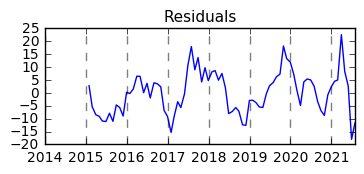

In [96]:
#model 1
X1 = df_mexico_sta[['Policy Rate y1',
                 'CT10 y1'
                   ]]
print('Model 1')
regress_y(df_mexico_sta, Y_y, X1)

results_mexico_1 = pd.read_excel('reg data dump.xlsx')
results_mexico_1['Dates'] = pd.to_datetime(results_mexico_1.Dates)
results_mexico_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.826723720365
                 Coefficients
const                3.075869
1Y ma2               0.577223
EQ Index YoY y1     -0.000109


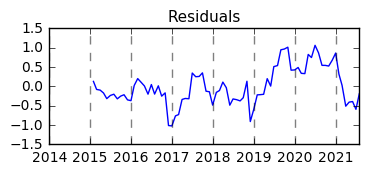

In [97]:
#model 2
X2 = df_mexico_sta[['1Y ma2',
                     'EQ Index YoY y1'
                   ]]
print('Model 2')
regress(Y, X2)

results_mexico_2 = pd.read_excel('reg data dump.xlsx')
results_mexico_2['Dates'] = pd.to_datetime(results_mexico_2.Dates)
results_mexico_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.897548932085
                 Coefficients
const                2.758883
Policy Rate          0.373532
CT10 ma2             0.801417
EQ Index YoY y1     -0.000063


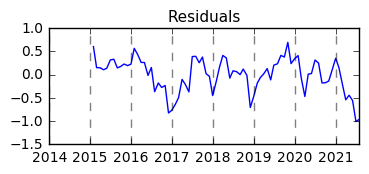

In [98]:
#model 3
X3 = df_mexico_sta[['Policy Rate',
                    'CT10 ma2',
                    'EQ Index YoY y1'
                   ]]
print('Model 3')
regress(Y, X3)

results_mexico_3 = pd.read_excel('reg data dump.xlsx')
results_mexico_3['Dates'] = pd.to_datetime(results_mexico_3.Dates)
results_mexico_3.set_index('Dates', inplace=True)

Model 4
R-Squared = 0.920010771778
                     Coefficients
const                    6.841344
GDP Forecast 1Y ma2     -1.175256
CT10 ma2                 1.291640
EQ Index YoY y1         -0.000061


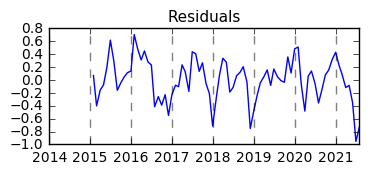

In [99]:
#model 4
X4 = df_mexico_sta[['GDP Forecast 1Y ma2',
                    'CT10 ma2',
                    'EQ Index YoY y1'
                   ]]
print('Model 4')
regress(Y, X4)

results_mexico_4 = pd.read_excel('reg data dump.xlsx')
results_mexico_4['Dates'] = pd.to_datetime(results_mexico_4.Dates)
results_mexico_4.set_index('Dates', inplace=True)

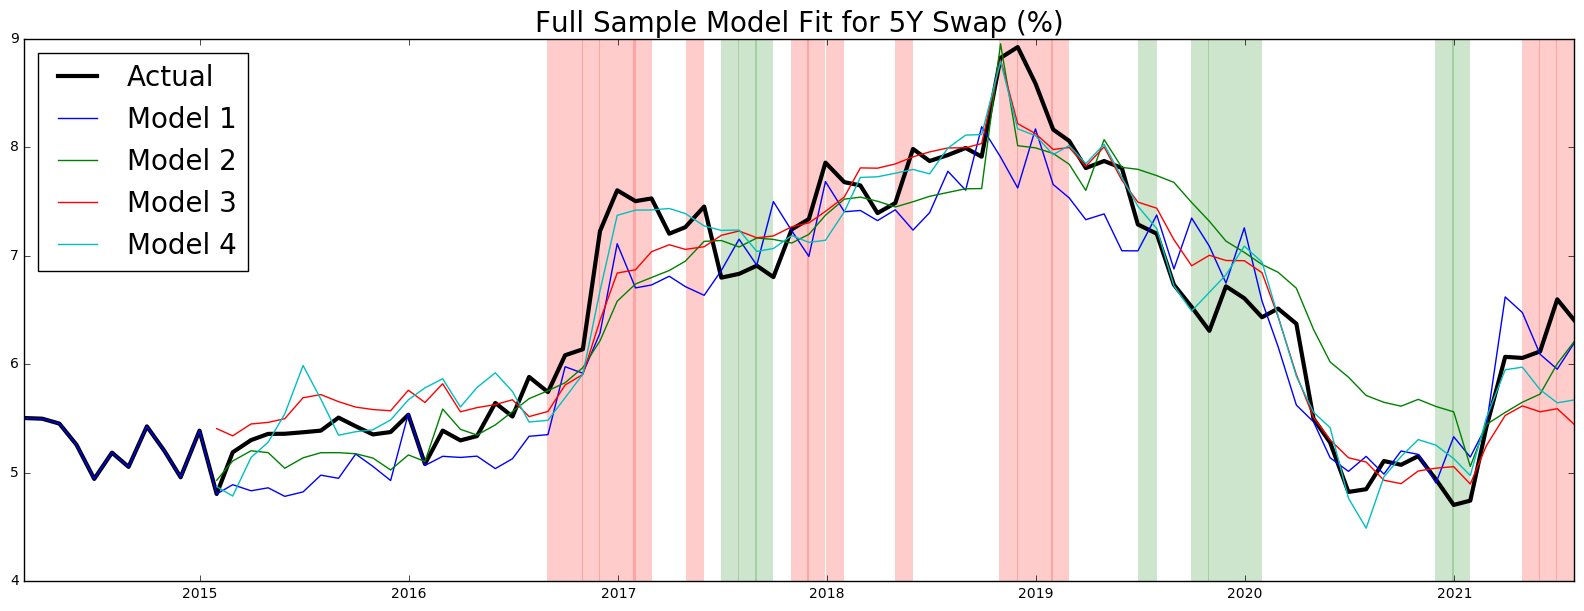

In [100]:
#collect model fits
results_mexico = pd.DataFrame(results_mexico_1['Actual 5Y Swap'])
results_mexico['Actual 5Y Swap'] = results_mexico_1['Actual 5Y Swap']
results_mexico['Model 1'] = results_mexico_1['Predictions']
results_mexico['Model 2'] = results_mexico_2['Predictions']
results_mexico['Model 3'] = results_mexico_3['Predictions']
results_mexico['Model 4'] = results_mexico_4['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_mexico['Regime'] = np.zeros_like(results_mexico['Actual 5Y Swap'])
for t in range(len(results_mexico)):
    if results_mexico['Model 1'][t] < results_mexico['Actual 5Y Swap'][t]\
    and results_mexico['Model 2'][t] < results_mexico['Actual 5Y Swap'][t]\
    and results_mexico['Model 3'][t] < results_mexico['Actual 5Y Swap'][t]\
    and results_mexico['Model 4'][t] < results_mexico['Actual 5Y Swap'][t]:
        results_mexico['Regime'][t] = -1
    
for t in range(len(results_mexico)):
    if results_mexico['Model 1'][t] > results_mexico['Actual 5Y Swap'][t]\
    and results_mexico['Model 2'][t] > results_mexico['Actual 5Y Swap'][t]\
    and results_mexico['Model 3'][t] > results_mexico['Actual 5Y Swap'][t]\
    and results_mexico['Model 4'][t] > results_mexico['Actual 5Y Swap'][t]:
        results_mexico['Regime'][t] = 1

results_mexico['Dates'] = results_mexico.index
results_mexico['Dates'] = results_mexico['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_mexico['Year'] = results_mexico['Dates'].dt.year
results_mexico['Month'] = results_mexico['Dates'].dt.month
results_mexico['Day'] = results_mexico['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_mexico = results_mexico.copy(deep = True)
regime_up_mexico.drop(regime_up_mexico[regime_up_mexico.Regime < 1].index, inplace = True)

regime_down_mexico = results_mexico.copy(deep = True)
regime_down_mexico.drop(regime_down_mexico[regime_down_mexico.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_mexico['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_mexico['Model 1'])
plt.plot(results_mexico['Model 2'])
plt.plot(results_mexico['Model 3'])
plt.plot(results_mexico['Model 4'])

for t in range(1, len(regime_up_mexico)):
    plt.axvspan(datetime(regime_up_mexico['Year'][t], regime_up_mexico['Month'][t], regime_up_mexico['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_mexico['Year'][t], regime_up_mexico['Month'][t], regime_up_mexico['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_mexico)):
    plt.axvspan(datetime(regime_down_mexico['Year'][t], regime_down_mexico['Month'][t], regime_down_mexico['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_mexico['Year'][t], regime_down_mexico['Month'][t], regime_down_mexico['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3', 'Model 4'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

****

## Brazil

In [101]:
#set dependent variables
Y = df_brazil_sta['5Y Swap']
Y_y = df_brazil_sta['5Y Swap y1']

Model 1
R-Squared = 0.69716487398
               Coefficients
const             -5.673732
USD/LC Vol y1      0.319832
1Y y1              0.323557


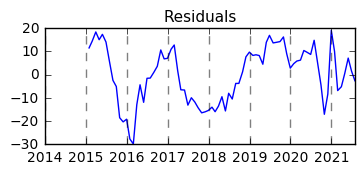

In [102]:
#model 1
X1 = df_brazil_sta[['USD/LC Vol y1',
                    '1Y y1'
                    ]]
print('Model 1')
regress_y(df_brazil_sta, Y_y, X1)

results_brazil_1 = pd.read_excel('reg data dump.xlsx')
results_brazil_1['Dates'] = pd.to_datetime(results_brazil_1.Dates)
results_brazil_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.846991081844
              Coefficients
const             5.151614
Policy Rate       0.548763
1Y y1             0.009471
USD/LC y1 p1      0.033566


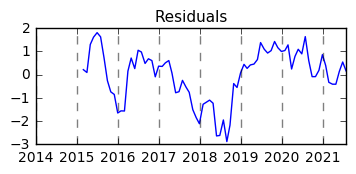

In [103]:
#model 2
X2 = df_brazil_sta[['Policy Rate',
                    '1Y y1',
                    'USD/LC y1 p1'
                    ]]
print('Model 2')
regress(Y, X2)

results_brazil_2 = pd.read_excel('reg data dump.xlsx')
results_brazil_2['Dates'] = pd.to_datetime(results_brazil_2.Dates)
results_brazil_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.474963972565
                       Coefficients
const                    -45.861442
CA Forecast 2Y ma2 p1    -14.112967
Gov Budget                -2.504194
Policy Rate z              6.316861


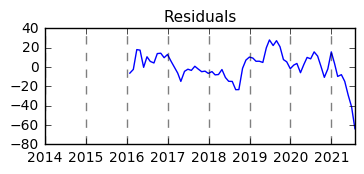

In [104]:
#model 3
X3 = df_brazil_sta[['CA Forecast 2Y ma2 p1',
                    'Gov Budget',
                    'Policy Rate z'
                    ]]
print('Model 3')
regress_y(df_brazil_sta, Y_y, X3)

results_brazil_3 = pd.read_excel('reg data dump.xlsx')
results_brazil_3['Dates'] = pd.to_datetime(results_brazil_3.Dates)
results_brazil_3.set_index('Dates', inplace=True)

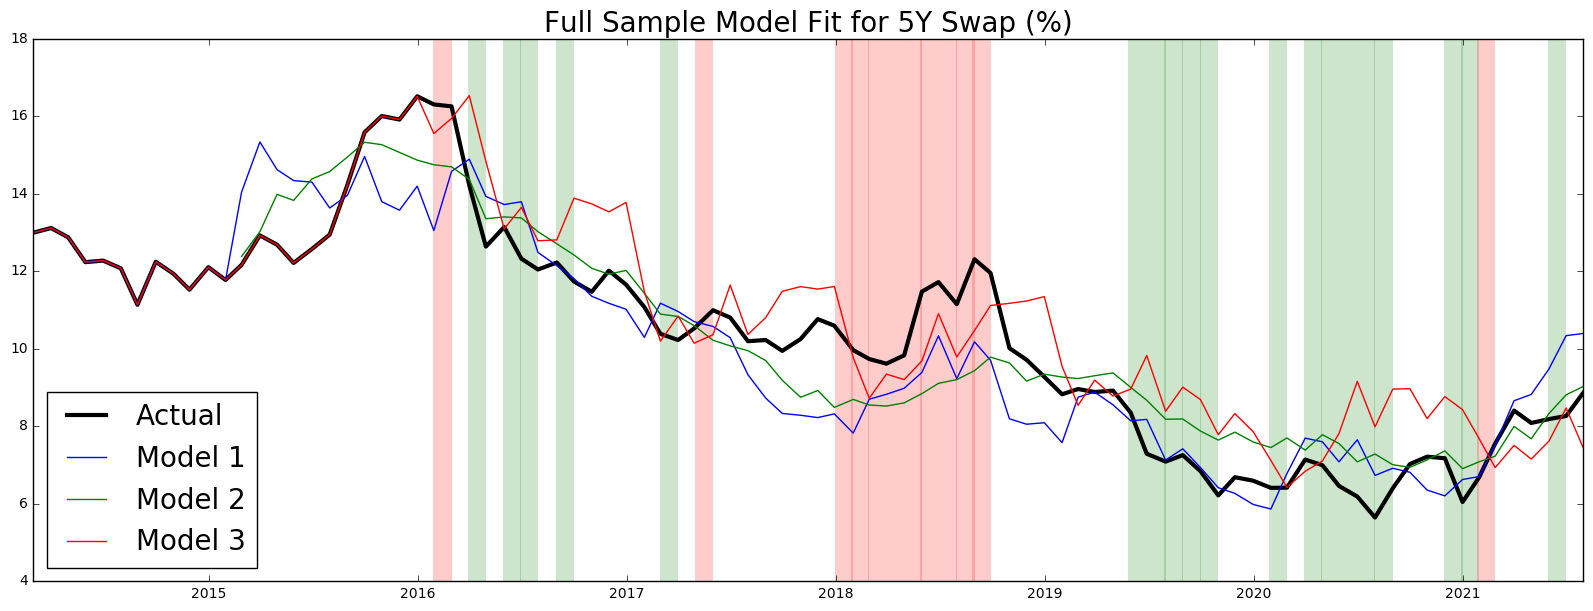

In [105]:
#collect model fits
results_brazil = pd.DataFrame(results_brazil_1['Actual 5Y Swap'])
results_brazil['Actual 5Y Swap'] = results_brazil_1['Actual 5Y Swap']
results_brazil['Model 1'] = results_brazil_1['Predictions']
results_brazil['Model 2'] = results_brazil_2['Predictions']
results_brazil['Model 3'] = results_brazil_3['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_brazil['Regime'] = np.zeros_like(results_brazil['Actual 5Y Swap'])
for t in range(len(results_brazil)):
    if results_brazil['Model 1'][t] < results_brazil['Actual 5Y Swap'][t]\
    and results_brazil['Model 2'][t] < results_brazil['Actual 5Y Swap'][t]\
    and results_brazil['Model 3'][t] < results_brazil['Actual 5Y Swap'][t]:
        results_brazil['Regime'][t] = -1
    
for t in range(len(results_brazil)):
    if results_brazil['Model 1'][t] > results_brazil['Actual 5Y Swap'][t]\
    and results_brazil['Model 2'][t] > results_brazil['Actual 5Y Swap'][t]\
    and results_brazil['Model 3'][t] > results_brazil['Actual 5Y Swap'][t]:
        results_brazil['Regime'][t] = 1

results_brazil['Dates'] = results_brazil.index
results_brazil['Dates'] = results_brazil['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_brazil['Year'] = results_brazil['Dates'].dt.year
results_brazil['Month'] = results_brazil['Dates'].dt.month
results_brazil['Day'] = results_brazil['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_brazil = results_brazil.copy(deep = True)
regime_up_brazil.drop(regime_up_brazil[regime_up_brazil.Regime < 1].index, inplace = True)

regime_down_brazil = results_brazil.copy(deep = True)
regime_down_brazil.drop(regime_down_brazil[regime_down_brazil.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_brazil['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_brazil['Model 1'])
plt.plot(results_brazil['Model 2'])
plt.plot(results_brazil['Model 3'])

for t in range(1, len(regime_up_brazil)):
    plt.axvspan(datetime(regime_up_brazil['Year'][t], regime_up_brazil['Month'][t], regime_up_brazil['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_brazil['Year'][t], regime_up_brazil['Month'][t], regime_up_brazil['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_brazil)):
    plt.axvspan(datetime(regime_down_brazil['Year'][t], regime_down_brazil['Month'][t], regime_down_brazil['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_brazil['Year'][t], regime_down_brazil['Month'][t], regime_down_brazil['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

***

## Chile

In [106]:
#set dependent variables
Y = df_chile_sta['5Y Swap']
Y_y = df_chile_sta['5Y Swap y1']

Model 1
R-Squared = 0.828394389348
           Coefficients
const         -7.218078
1Y y1          0.610894
Rating y1     -6.909246


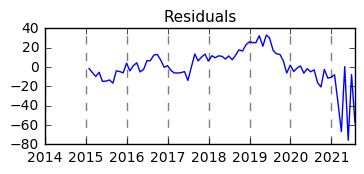

In [107]:
#model 1
X1 = df_chile_sta[['1Y y1',
                   'Rating y1'
                    ]]
print('Model 1')
regress_y(df_chile_sta, Y_y, X1)

results_chile_1 = pd.read_excel('reg data dump.xlsx')
results_chile_1['Dates'] = pd.to_datetime(results_chile_1.Dates)
results_chile_1.set_index('Dates', inplace=True)

Model 2
R-Squared = 0.834945255278
                              Coefficients
const                             1.686687
1Y ma2                            0.623805
Gov Effectiveness Monthly y1     -0.017154
Gov Budget Forecast 1Y y1        -0.001422


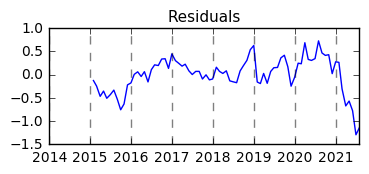

In [108]:
#model 2
X2 = df_chile_sta[['1Y ma2',
                   'Gov Effectiveness Monthly y1',
                   'Gov Budget Forecast 1Y y1'
                    ]]
print('Model 2')
regress(Y, X2)

results_chile_2 = pd.read_excel('reg data dump.xlsx')
results_chile_2['Dates'] = pd.to_datetime(results_chile_2.Dates)
results_chile_2.set_index('Dates', inplace=True)

Model 3
R-Squared = 0.758419001044
                              Coefficients
const                             1.367772
CT10 ma2                          0.880910
Gov Effectiveness Monthly y1     -0.010167
CPI Forecast 2Y z                 0.120076


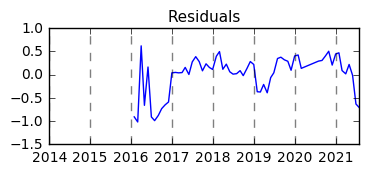

In [109]:
#model 3
X3 = df_chile_sta[['CT10 ma2',
                   'Gov Effectiveness Monthly y1',
                   'CPI Forecast 2Y z'
                    ]]
print('Model 3')
regress(Y, X3)

results_chile_3 = pd.read_excel('reg data dump.xlsx')
results_chile_3['Dates'] = pd.to_datetime(results_chile_3.Dates)
results_chile_3.set_index('Dates', inplace=True)

Model 4
R-Squared = 0.738737170647
                              Coefficients
const                            -7.217140
Gov Effectiveness Monthly y1     -0.015470
Trade Bal as % GDP SA z          -0.360711
CPI Forecast 2Y ma3               3.430052
Gov Budget as % GDP SA y1        -0.000185


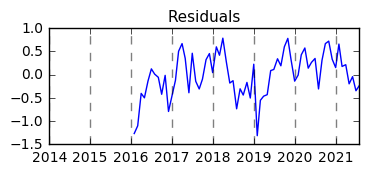

In [110]:
#model 4
X4 = df_chile_sta[['Gov Effectiveness Monthly y1',
                   'Trade Bal as % GDP SA z',
                   'CPI Forecast 2Y ma3',
                   'Gov Budget as % GDP SA y1'
                    ]]
print('Model 4')
regress(Y, X4)

results_chile_4 = pd.read_excel('reg data dump.xlsx')
results_chile_4['Dates'] = pd.to_datetime(results_chile_4.Dates)
results_chile_4.set_index('Dates', inplace=True)

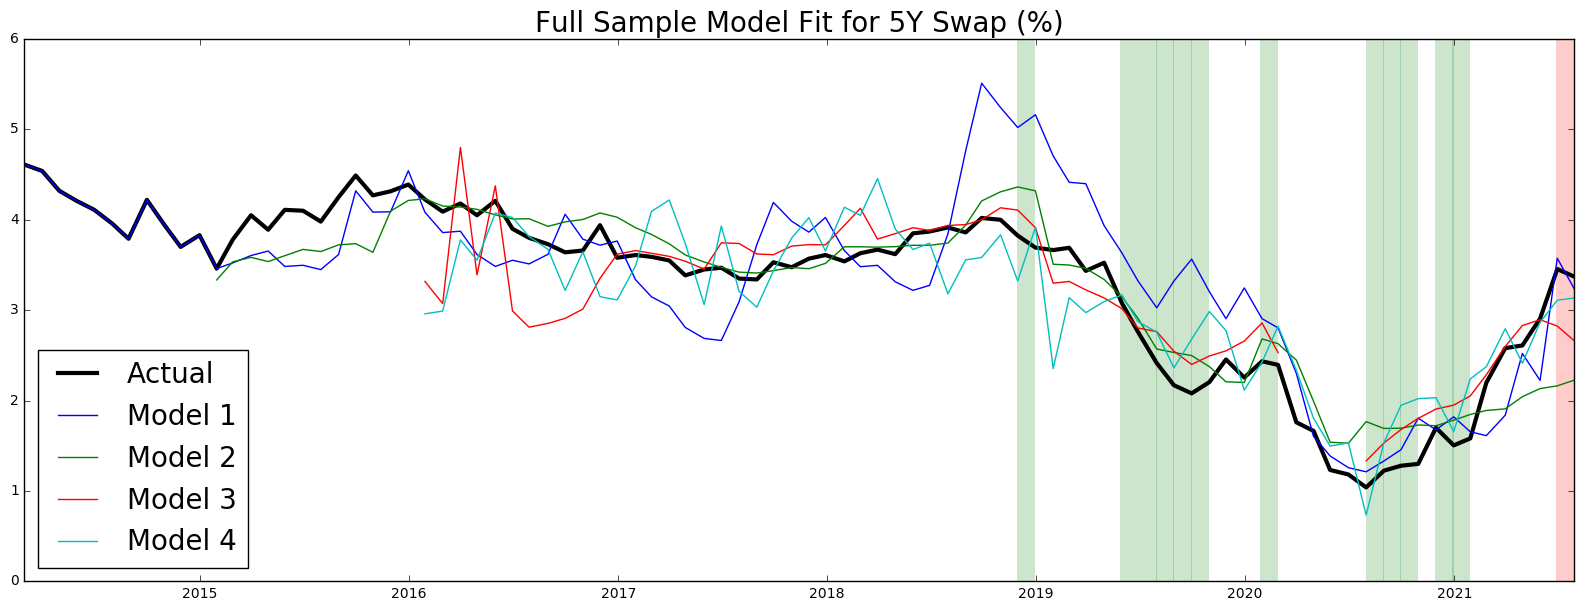

In [111]:
#collect model fits
results_chile = pd.DataFrame(results_chile_1['Actual 5Y Swap'])
results_chile['Actual 5Y Swap'] = results_chile_1['Actual 5Y Swap']
results_chile['Model 1'] = results_chile_1['Predictions']
results_chile['Model 2'] = results_chile_2['Predictions']
results_chile['Model 3'] = results_chile_3['Predictions']
results_chile['Model 4'] = results_chile_4['Predictions']

#creating dummy for regimes (when all models are higher or lower than actual 5Y Swap)
results_chile['Regime'] = np.zeros_like(results_chile['Actual 5Y Swap'])
for t in range(len(results_chile)):
    if results_chile['Model 1'][t] < results_chile['Actual 5Y Swap'][t]\
    and results_chile['Model 2'][t] < results_chile['Actual 5Y Swap'][t]\
    and results_chile['Model 3'][t] < results_chile['Actual 5Y Swap'][t]\
    and results_chile['Model 4'][t] < results_chile['Actual 5Y Swap'][t]:
        results_chile['Regime'][t] = -1
    
for t in range(len(results_chile)):
    if results_chile['Model 1'][t] > results_chile['Actual 5Y Swap'][t]\
    and results_chile['Model 2'][t] > results_chile['Actual 5Y Swap'][t]\
    and results_chile['Model 3'][t] > results_chile['Actual 5Y Swap'][t]\
    and results_chile['Model 4'][t] > results_chile['Actual 5Y Swap'][t]:
        results_chile['Regime'][t] = 1

results_chile['Dates'] = results_chile.index
results_chile['Dates'] = results_chile['Dates'].apply(lambda x : pd.to_datetime(str(x)))

results_chile['Year'] = results_chile['Dates'].dt.year
results_chile['Month'] = results_chile['Dates'].dt.month
results_chile['Day'] = results_chile['Dates'].dt.day

#create dataframe for only regimes up or down
regime_up_chile = results_chile.copy(deep = True)
regime_up_chile.drop(regime_up_chile[regime_up_chile.Regime < 1].index, inplace = True)

regime_down_chile = results_chile.copy(deep = True)
regime_down_chile.drop(regime_down_chile[regime_down_chile.Regime > -1].index, inplace = True)

#plot model fits
plt.figure(figsize=(20,7))
plt.plot(results_chile['Actual 5Y Swap'], linewidth = 3, color = 'black')
plt.plot(results_chile['Model 1'])
plt.plot(results_chile['Model 2'])
plt.plot(results_chile['Model 3'])
plt.plot(results_chile['Model 4'])

for t in range(1, len(regime_up_chile)):
    plt.axvspan(datetime(regime_up_chile['Year'][t], regime_up_chile['Month'][t], regime_up_chile['Day'][t]) - timedelta(days=32),\
                datetime(regime_up_chile['Year'][t], regime_up_chile['Month'][t], regime_up_chile['Day'][t]), facecolor='green', alpha=.2, edgecolor = 'none')

for t in range(1, len(regime_down_chile)):
    plt.axvspan(datetime(regime_down_chile['Year'][t], regime_down_chile['Month'][t], regime_down_chile['Day'][t]) - timedelta(days=32),\
                datetime(regime_down_chile['Year'][t], regime_down_chile['Month'][t], regime_down_chile['Day'][t]), facecolor='red', alpha=.2, edgecolor = 'none')

plt.legend(('Actual', 'Model 1', 'Model 2', 'Model 3', 'Model 4'), fontsize = 20, loc = 'best')
plt.title('Full Sample Model Fit for 5Y Swap (%)', fontsize = 20)
plt.show()

***

## Summary

In [112]:
## Analyze cross-section for latest estimate

In [113]:
#list of countries
countries = ['Hungary',
             'Poland',
             'Czech',
             'Israel',
             'South Africa',
             'Russia',
             'Turkey',
             'Indonesia',
             'Thailand',
             
             'India',
             'Korea',
             'China',
             'Mexico',
             'Brazil',
             'Chile'
             
            ]

In [116]:
#create list of latest actual 5Y Swap
latest_5Y_Swap = [results_hungary['Actual 5Y Swap'][-1],
              results_poland['Actual 5Y Swap'][-1],
              results_czech['Actual 5Y Swap'][-1],
              results_israel['Actual 5Y Swap'][-1],
              results_southafrica['Actual 5Y Swap'][-1],
              results_russia['Actual 5Y Swap'][-1],
              results_turkey['Actual 5Y Swap'][-1],
              results_indonesia['Actual 5Y Swap'][-1],
              results_thailand['Actual 5Y Swap'][-1],
              
              results_india['Actual 5Y Swap'][-1],
              results_korea['Actual 5Y Swap'][-1],
              results_china['Actual 5Y Swap'][-1],
              results_mexico['Actual 5Y Swap'][-1],
              results_brazil['Actual 5Y Swap'][-1],
              results_chile['Actual 5Y Swap'][-1]
             
              ]

In [117]:
# Number of models

# Hungary:4
# Poland:4
# Czech:3
# Israel:2
# South Africa:3
# Russia:4
# Turkey:2
# Indonesia:3
# Thailand:3
# Philippines:4
# India:3
# Korea:3
# China:2
# Mexico:4
# Brazil:3
# Chile:4
# Colombia:4
# Peru:4

In [118]:
#create lists for model forecasts
model_1 = [results_hungary['Model 1'][-1],
           results_poland['Model 1'][-1],
           results_czech['Model 1'][-1],
           results_israel['Model 1'][-1],
           results_southafrica['Model 1'][-1],
           results_russia['Model 1'][-1],
           results_turkey['Model 1'][-1],
           results_indonesia['Model 1'][-1],
           results_thailand['Model 1'][-1],
          
           results_india['Model 1'][-1],
           results_korea['Model 1'][-1],
           results_china['Model 1'][-1],
           results_mexico['Model 1'][-1],
           results_brazil['Model 1'][-1],
           results_chile['Model 1'][-1],
           
           ]

In [119]:
#create lists for model forecasts
model_2 = [results_hungary['Model 2'][-1],
           results_poland['Model 2'][-1],
           results_czech['Model 2'][-1],
           results_israel['Model 2'][-1],
           results_southafrica['Model 2'][-1],
           results_russia['Model 2'][-1],
           results_turkey['Model 2'][-1],
           results_indonesia['Model 2'][-1],
           results_thailand['Model 2'][-1],
           
           results_india['Model 2'][-1],
           results_korea['Model 2'][-1],
           results_china['Model 2'][-1],
           results_mexico['Model 2'][-1],
           results_brazil['Model 2'][-1],
           results_chile['Model 2'][-1],
           
           ]

In [120]:
#create lists for model forecasts
model_3 = [results_hungary['Model 3'][-1],
           results_poland['Model 3'][-1],
           results_czech['Model 3'][-1],
           0,
           results_southafrica['Model 3'][-1],
           results_russia['Model 3'][-1],
           0,
           results_indonesia['Model 3'][-1],
           results_thailand['Model 3'][-1],
          
           results_india['Model 3'][-1],
           results_korea['Model 3'][-1],
           0,
           results_mexico['Model 3'][-1],
           results_brazil['Model 3'][-1],
           results_chile['Model 3'][-1]
           
           ]

In [121]:
#create lists for model forecasts
model_4 = [results_hungary['Model 4'][-1],
           results_poland['Model 4'][-1],
           0,
           0,
           0,
           results_russia['Model 4'][-1],
           0,
           0,
           0,
          
           0,
           0,
           0,
           results_mexico['Model 4'][-1],
           0,
           results_chile['Model 4'][-1]
           
           ]

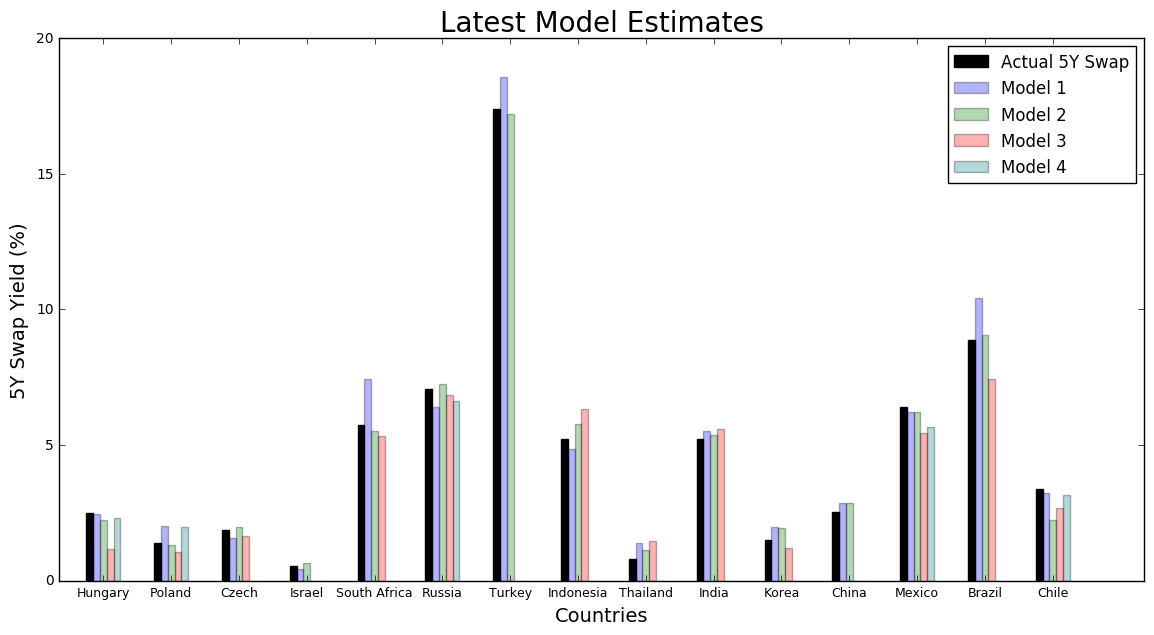

In [124]:
#plot bar chart
n = len(countries)
r = np.arange(n) + 0.4
width = 0.1
  
plt.figure(figsize=(14,7))
plt.bar(r, latest_5Y_Swap, color = 'black',
        width = width, edgecolor = 'black',
        label='Actual 5Y Swap')
plt.bar(r + width , model_1, color = 'blue', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 1')
plt.bar(r + width + 0.1, model_2, color = 'green', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 2')
plt.bar(r + width + 0.2, model_3, color = 'red', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 3')
plt.bar(r + width + 0.3, model_4, color='teal', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 4')
  
plt.xlabel('Countries', fontsize = 14)
plt.ylabel('5Y Swap Yield (%)', fontsize = 14)
plt.title('Latest Model Estimates', fontsize = 20)
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2 +0.2,countries, fontsize=9)
plt.legend()
  
plt.show()

In [127]:
#create list for residuals
residuals_1 = [results_hungary['Model 1'][-1] - results_hungary['Actual 5Y Swap'][-1],
               results_poland['Model 1'][-1] - results_poland['Actual 5Y Swap'][-1],
               results_czech['Model 1'][-1] - results_czech['Actual 5Y Swap'][-1],
               results_israel['Model 1'][-1] - results_israel['Actual 5Y Swap'][-1],
               results_southafrica['Model 1'][-1] - results_southafrica['Actual 5Y Swap'][-1],
               results_russia['Model 1'][-1] - results_russia['Actual 5Y Swap'][-1],
               results_turkey['Model 1'][-1] - results_turkey['Actual 5Y Swap'][-1],
               results_indonesia['Model 1'][-1] - results_indonesia['Actual 5Y Swap'][-1],
               results_thailand['Model 1'][-1] - results_thailand['Actual 5Y Swap'][-1],
               
               results_india['Model 1'][-1] - results_india['Actual 5Y Swap'][-1],
               results_korea['Model 1'][-1] - results_korea['Actual 5Y Swap'][-1],
               results_china['Model 1'][-1] - results_china['Actual 5Y Swap'][-1],
               results_mexico['Model 1'][-1] - results_mexico['Actual 5Y Swap'][-1],
               results_brazil['Model 1'][-1] - results_brazil['Actual 5Y Swap'][-1],
               results_chile['Model 1'][-1] - results_chile['Actual 5Y Swap'][-1],
               
              ]

In [128]:
#create list for residuals
residuals_2 = [results_hungary['Model 2'][-1] - results_hungary['Actual 5Y Swap'][-1],
               results_poland['Model 2'][-1] - results_poland['Actual 5Y Swap'][-1],
               results_czech['Model 2'][-1] - results_czech['Actual 5Y Swap'][-1],
               results_israel['Model 2'][-1] - results_israel['Actual 5Y Swap'][-1],
               results_southafrica['Model 2'][-1] - results_southafrica['Actual 5Y Swap'][-1],
               results_russia['Model 2'][-1] - results_russia['Actual 5Y Swap'][-1],
               results_turkey['Model 2'][-1] - results_turkey['Actual 5Y Swap'][-1],
               results_indonesia['Model 2'][-1] - results_indonesia['Actual 5Y Swap'][-1],
               results_thailand['Model 2'][-1] - results_thailand['Actual 5Y Swap'][-1],
              
               results_india['Model 2'][-1] - results_india['Actual 5Y Swap'][-1],
               results_korea['Model 2'][-1] - results_korea['Actual 5Y Swap'][-1],
               results_china['Model 2'][-1] - results_china['Actual 5Y Swap'][-1],
               results_mexico['Model 2'][-1] - results_mexico['Actual 5Y Swap'][-1],
               results_brazil['Model 2'][-1] - results_brazil['Actual 5Y Swap'][-1],
               results_chile['Model 2'][-1] - results_chile['Actual 5Y Swap'][-1]
               
              ]

In [129]:
#create list for residuals
residuals_3 = [results_hungary['Model 3'][-1] - results_hungary['Actual 5Y Swap'][-1],
               results_poland['Model 3'][-1] - results_poland['Actual 5Y Swap'][-1],
               results_czech['Model 3'][-1] - results_czech['Actual 5Y Swap'][-1],
               np.nan,
               results_southafrica['Model 3'][-1] - results_southafrica['Actual 5Y Swap'][-1],
               results_russia['Model 3'][-1] - results_russia['Actual 5Y Swap'][-1],
               np.nan,
               results_indonesia['Model 3'][-1] - results_indonesia['Actual 5Y Swap'][-1],
               results_thailand['Model 3'][-1] - results_thailand['Actual 5Y Swap'][-1],
               
               results_india['Model 3'][-1] - results_india['Actual 5Y Swap'][-1],
               results_korea['Model 3'][-1] - results_korea['Actual 5Y Swap'][-1],
               np.nan,
               results_mexico['Model 3'][-1] - results_mexico['Actual 5Y Swap'][-1],
               results_brazil['Model 3'][-1] - results_brazil['Actual 5Y Swap'][-1],
               results_chile['Model 3'][-1] - results_chile['Actual 5Y Swap'][-1]
               
              ]

In [130]:
#create list for residuals
residuals_4 = [results_hungary['Model 4'][-1] - results_hungary['Actual 5Y Swap'][-1],
               results_poland['Model 4'][-1] - results_poland['Actual 5Y Swap'][-1],
               np.nan,
               np.nan,
               np.nan,
               results_russia['Model 4'][-1] - results_russia['Actual 5Y Swap'][-1],
               np.nan,
               np.nan,
               np.nan,
               
               np.nan,
               np.nan,
               np.nan,
               results_mexico['Model 4'][-1] - results_mexico['Actual 5Y Swap'][-1],
               np.nan,
               results_chile['Model 4'][-1] - results_chile['Actual 5Y Swap'][-1],
              
              ]

In [131]:
#average of residuals
residuals = pd.DataFrame(index = countries)
residuals['Model 1'] = residuals_1
residuals['Model 2'] = residuals_2
residuals['Model 3'] = residuals_3
residuals['Model 4'] = residuals_4
residuals['Average'] = residuals.mean(axis = 1)

In [132]:
#convert residuals into basis points
residuals_bps = residuals*100

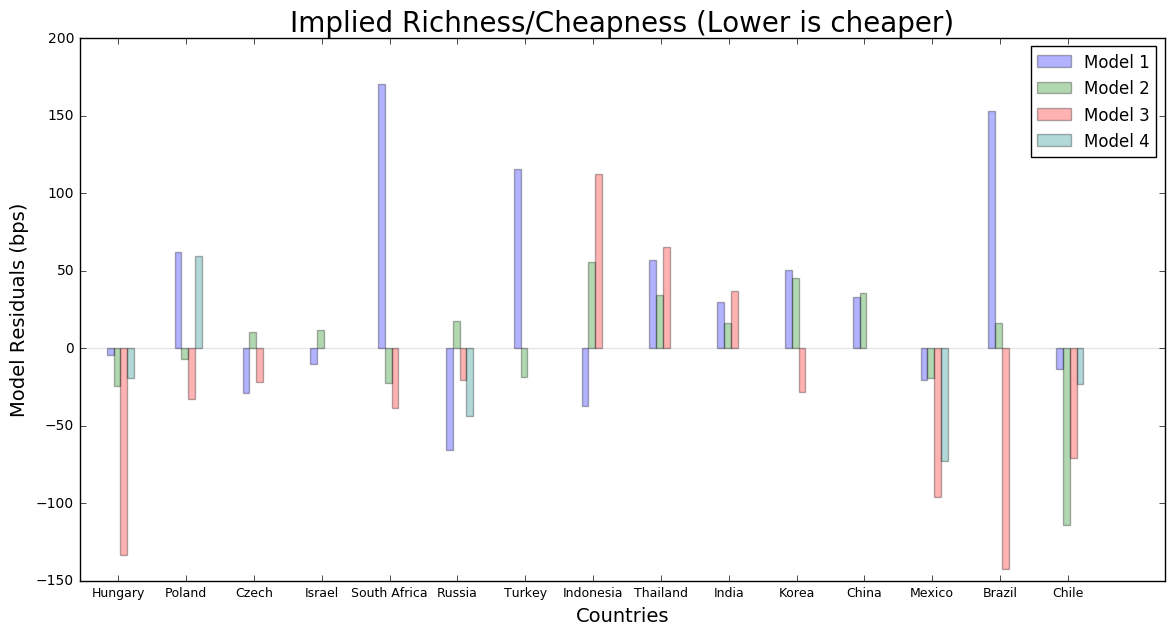

In [133]:
#plot bar chart for residuals
n = len(countries)
r = np.arange(n) + 0.4
width = 0.1
  
plt.figure(figsize=(14,7))

plt.bar(r  , residuals_bps['Model 1'], color = 'blue', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 1')
plt.bar(r + width , residuals_bps['Model 2'], color = 'green', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 2')
plt.bar(r + width + 0.1, residuals_bps['Model 3'], color = 'red', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 3')
plt.bar(r + width + 0.2, residuals_bps['Model 4'], color='teal', alpha = 0.3,
        width = width, edgecolor = 'black',
        label='Model 4')
  
plt.xlabel('Countries', fontsize = 14)
plt.ylabel('Model Residuals (bps)', fontsize = 14)
plt.title('Implied Richness/Cheapness (Lower is cheaper)', fontsize = 20)
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2 + 0.12,countries, fontsize=9)
plt.legend(loc = 'best')
plt.axhline(0, color = 'black', alpha = 0.1)
  
plt.show()

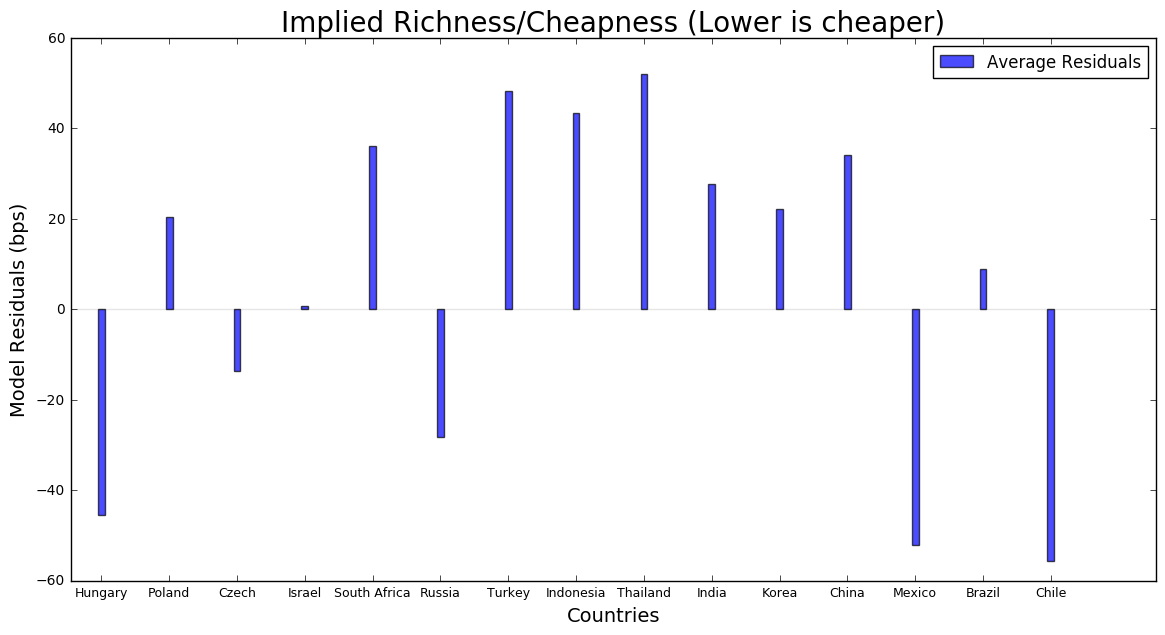

In [134]:
#plot bar chart for average residuals
n = len(countries)
r = np.arange(n) + 0.4
width = 0.1
  
plt.figure(figsize=(14,7))

plt.bar(r  , residuals_bps['Average'], color = 'blue', alpha = 0.7,
        width = width, edgecolor = 'black',
        label='Average Residuals')
  
plt.xlabel('Countries', fontsize = 14)
plt.ylabel('Model Residuals (bps)', fontsize = 14)
plt.title('Implied Richness/Cheapness (Lower is cheaper)', fontsize = 20)
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2 ,countries, fontsize=9)
plt.legend(loc = 'best')
plt.axhline(0, color = 'black', alpha = 0.1)
  
plt.show()